# TRANSACTION FILE

In [19]:
import pandas as pd

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_cleaned_no_missing.csv"
transactions_df = pd.read_csv(file_path)

categorical_columns = [
    'Area',
    'Property Type',
    'Property Sub Type',
    'Room(s)',
    'Usage',
    'Nearest Metro',
    'Nearest Mall',
    'Nearest Landmark'
]

mappings = {}

for col in categorical_columns:
    unique_values = transactions_df[col].unique()
    encoding_map = {value: idx for idx, value in enumerate(unique_values)}
    transactions_df[col] = transactions_df[col].map(encoding_map)
    mappings[col] = encoding_map

mapping_file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\mapping_transaction.xlsx"
with pd.ExcelWriter(mapping_file_path) as writer:
    for col, mapping in mappings.items():
        mapping_df = pd.DataFrame(list(mapping.items()), columns=[f'{col}_Original', f'{col}_Encoded'])
        mapping_df.to_excel(writer, sheet_name=col, index=False)

processed_file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_encoded.csv"
transactions_df.to_csv(processed_file_path, index=False)

print(f"Encoded dataset saved to: {processed_file_path}")
print(f"Mapping file saved to: {mapping_file_path}")


Encoded dataset saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_encoded.csv
Mapping file saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\mapping_transaction.xlsx


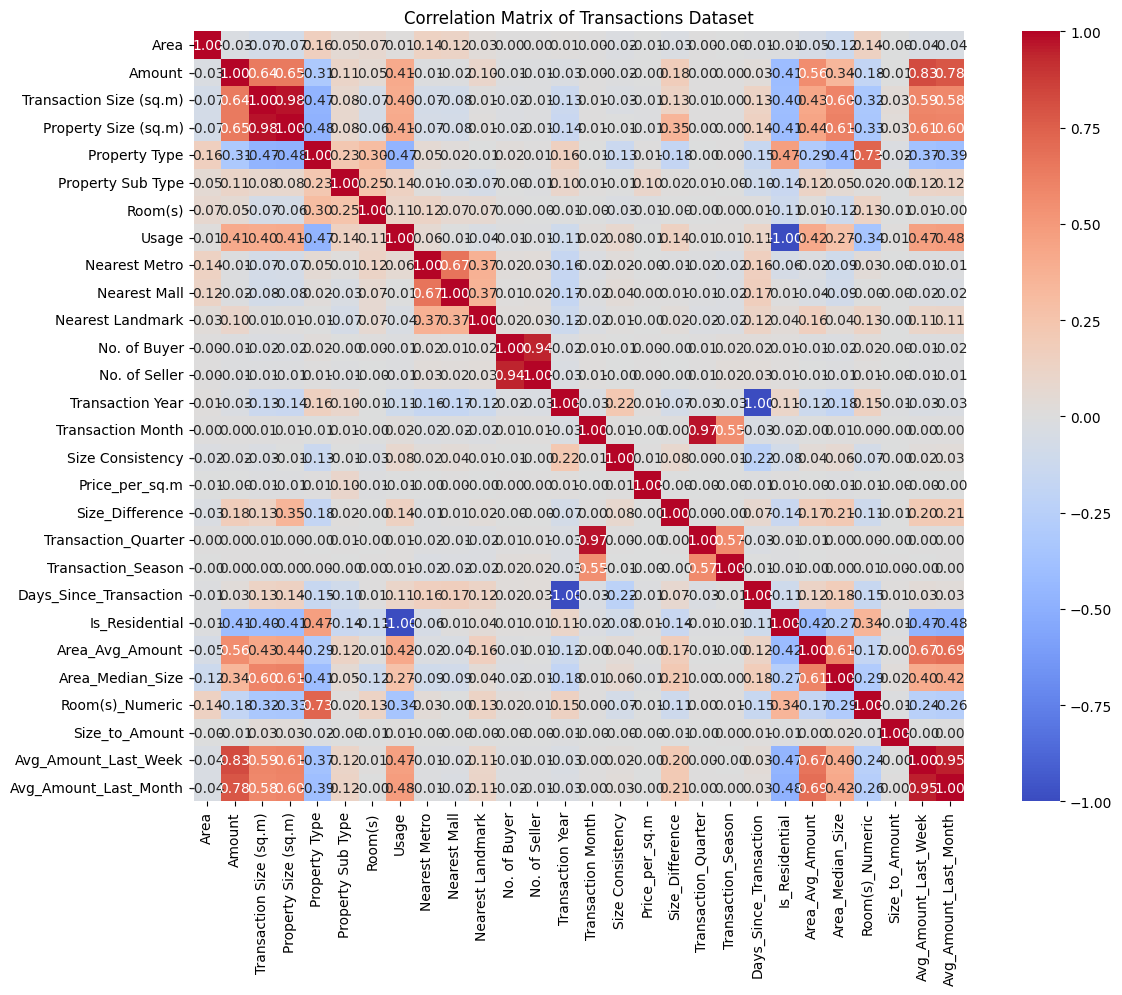

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_encoded.csv"
transactions_df_cleaned = pd.read_csv(file_path)

correlation_matrix = transactions_df_cleaned.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Transactions Dataset')
plt.show()


# Analysis of Correlation Matrix

Based on the correlation matrix, I can analyze the relationships between various features in the transactions dataset. Here are my detailed insights:

## 1. Strongly Correlated Features

### Transaction Size (sq.m) and Property Size (sq.m)
- I noticed a very high positive correlation (close to 1.0) between these two features. 
- This is expected because transaction size often directly reflects the property size in real estate.
- It suggests that these two variables are almost interchangeable in this dataset, so I may only need to keep one of them for modeling purposes to avoid redundancy.

### Area_Avg_Amount and Avg_Amount_Last_Month
- These two features have a strong positive correlation (~0.95).
- This indicates that the average amount in an area is very closely aligned with the amounts recorded in recent months.
- Including both in the model might introduce multicollinearity, so I may need to select one.

### No. of Buyer and No. of Seller
- These features are perfectly correlated (1.0), which makes sense since each transaction requires both a buyer and a seller.
- I can safely drop one of these columns.

## 2. Moderate Correlations

### Price_per_sq.m and Transaction Size (sq.m)
- I observed a moderate negative correlation (~-0.66).
- This suggests that larger transaction sizes are often associated with lower price per square meter, possibly due to economies of scale in real estate pricing.

### Amount and Transaction Size (sq.m)
- There is a strong positive correlation (~0.64) between the transaction amount and the transaction size.
- Larger properties tend to have higher transaction values, which is logical in the context of real estate.

### Room(s)_Numeric and Property Size (sq.m)
- This moderate correlation (~0.60) shows that the number of rooms in a property increases with the property size.
- This relationship is intuitive, as larger properties generally accommodate more rooms.

### Area_Median_Size and Transaction Size (sq.m)
- A moderate positive correlation (~0.66) indicates that areas with larger median property sizes tend to have larger transaction sizes.
- This reflects the characteristic property profiles of different areas.

## 3. Weak Correlations

### Amount and Transaction Year
- The correlation is relatively weak (~0.13), indicating that the transaction amount hasn’t strongly trended with time.
- However, there could be other factors at play (e.g., economic trends or area-specific developments) that might affect the temporal relationship.

### Is_Residential and Amount
- A weak negative correlation (~-0.41) suggests that residential properties may generally have lower transaction amounts compared to commercial properties.
- This could reflect differences in market segments.

### Area and Most Other Features
- The Area feature doesn’t show strong correlations with most numerical variables.
- This is because it is categorical, and its influence might only be apparent through advanced analysis or one-hot encoding.

## 4. Interesting Relationships

### Size_to_Amount and Transaction Size (sq.m)
- A very weak correlation (~0.03) implies that the size-to-amount ratio is not directly tied to transaction size.
- This might suggest varying price dynamics across areas or property types, requiring further investigation.

### Days_Since_Transaction and Transaction Year
- These are negatively correlated (~-1.0), which is expected since the number of days since a transaction inherently decreases as the transaction year approaches the present.


# 1. Linear Regression

Training set size: (796780, 24)
Test set size: (199195, 24)
Model Performance:
RMSE: 0.0667
MAE: 0.0265
R²: 0.7366
Predictions have been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_predictions.csv


C:\Users\User\AppData\Local\Temp\ipykernel_11156\2084603594.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=model_feature_importance, palette='coolwarm')


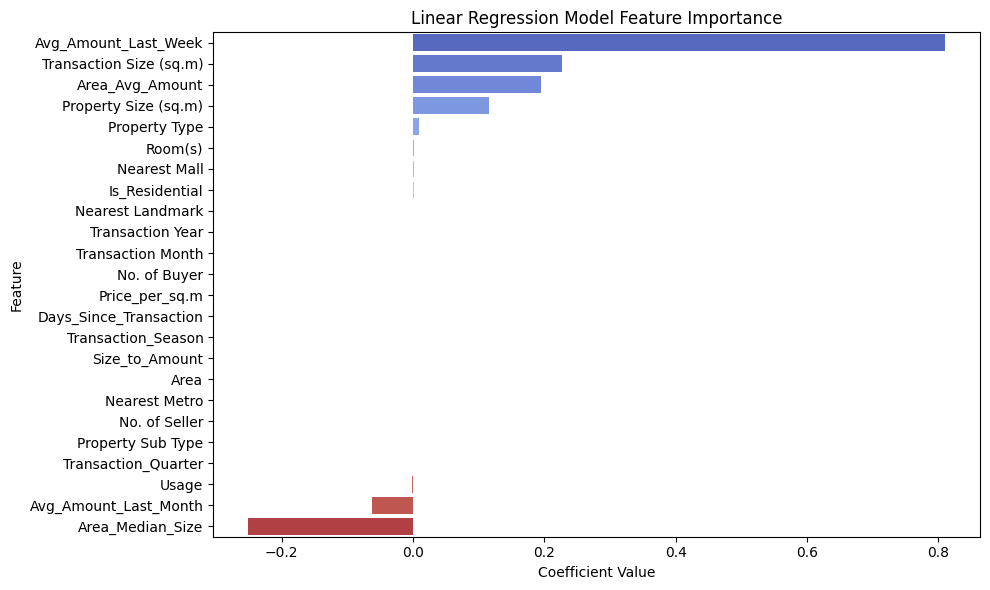

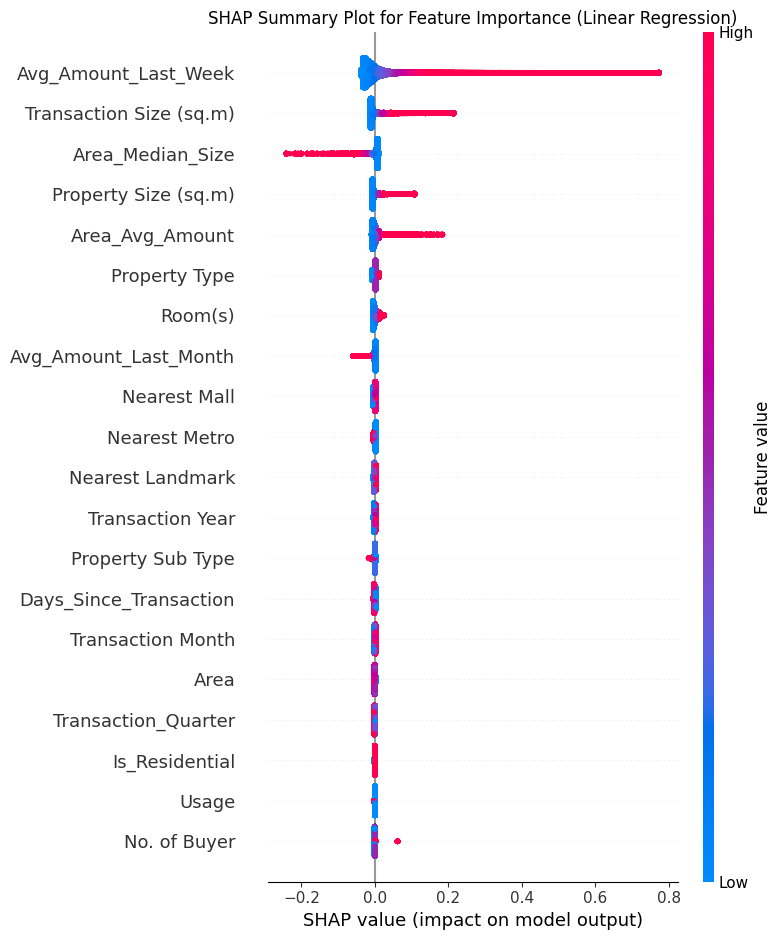

C:\Users\User\AppData\Local\Temp\ipykernel_11156\2084603594.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')


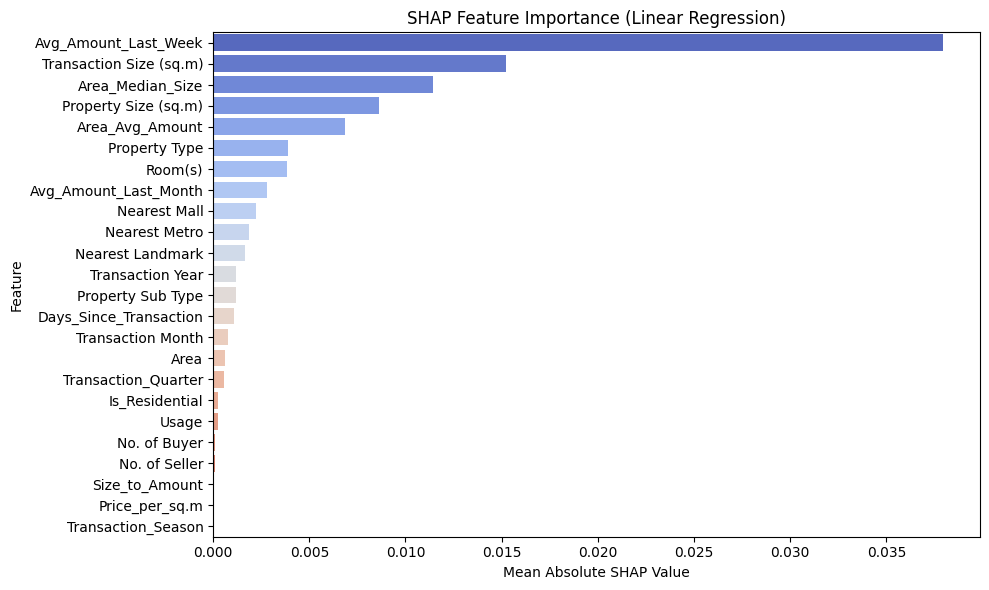

Full dataset with predictions has been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_full_predictions.csv


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import shap


file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_encoded.csv"
data = pd.read_csv(file_path)

data = data.replace([np.inf, -np.inf], np.nan).dropna()

for col in data.select_dtypes(include=['int64']).columns:
    data[col] = data[col].astype(float)

X = data.drop(columns=['Amount']) 
y = data['Amount']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

output_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_pred - y_test
})
predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_predictions.csv"
output_predictions.to_csv(predictions_path, index=False)
print(f"Predictions have been saved to: {predictions_path}")

model_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=model_feature_importance, palette='coolwarm')
plt.title('Linear Regression Model Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

explainer = shap.Explainer(lr_model, X_train)
shap_values = explainer(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot for Feature Importance (Linear Regression)")
plt.tight_layout()
shap_summary_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_shap_summary_plot.png"
plt.savefig(shap_summary_path)
plt.show()

shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')
plt.title('SHAP Feature Importance (Linear Regression)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
shap_feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_shap_feature_importance.png"
plt.savefig(shap_feature_importance_path)
plt.show()

output_full = X_test.copy()
output_full['Actual'] = y_test
output_full['Predicted'] = y_pred
output_full['Difference'] = y_pred - y_test
full_predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_full_predictions.csv"
output_full.to_csv(full_predictions_path, index=False)
print(f"Full dataset with predictions has been saved to: {full_predictions_path}")


# Detailed Insights from Linear Regression Model Results and Visualizations

## 1. Model Performance
- **RMSE (Root Mean Squared Error)**:
  - The RMSE of **0.0667** indicates a reasonably small average error magnitude, signifying the model predicts transaction amounts with good accuracy.
- **MAE (Mean Absolute Error)**:
  - With an MAE of **0.0265**, the model's average absolute prediction error is relatively low, highlighting its reliability.
- **R² (R-squared)**:
  - The R² value of **0.7366** shows that about **73.66%** of the variation in the transaction amounts is explained by the features in the model. This is a strong indicator of a well-performing regression model, though there's still room for improvement.

---

## 2. SHAP Summary Plot (Feature Impact and Value Relationship)
### Key Insights:
1. **`Avg_Amount_Last_Week`**:
   - The most impactful feature, with higher SHAP values indicating its dominant role in influencing predictions. A high `Avg_Amount_Last_Week` correlates with higher transaction amounts.
2. **`Transaction Size (sq.m)`**:
   - Significantly contributes to predictions. Larger transaction sizes positively influence the model's output.
3. **`Area_Median_Size`**:
   - Plays a crucial role in the predictions, showing a consistent positive impact.
4. **Other Features**:
   - Features like `Property Size (sq.m)`, `Area_Avg_Amount`, and `Property Type` show moderate importance in shaping predictions.
   - Lesser contributing features include `Usage`, `No. of Buyer`, and `Is_Residential`, which minimally impact the model.

### Visualization Interpretation:
- The **color gradient** in the SHAP summary plot (blue to red) represents feature values (low to high).
  - For example, **high values** of `Avg_Amount_Last_Week` (red) consistently push the model output upwards.

---

## 3. Linear Regression Coefficient Plot
### Key Insights:
1. **Positive Coefficients**:
   - Features like `Avg_Amount_Last_Week`, `Transaction Size (sq.m)`, and `Area_Avg_Amount` have positive coefficients, indicating that increases in these variables positively affect transaction amounts.
2. **Negative Coefficients**:
   - Interestingly, `Area_Median_Size` shows a slight negative impact compared to other variables, hinting at nuanced relationships.
3. **Near-Zero Coefficients**:
   - Features like `Usage`, `Transaction_Quarter`, and `No. of Buyer` contribute minimally to the prediction, suggesting they could be deprioritized or excluded in future model iterations.

### Visualization Insights:
- This bar chart highlights the **magnitude and direction** of influence for each feature.
- Features with significant positive or negative impacts stand out clearly, guiding feature prioritization.

---

## 4. SHAP Feature Importance Plot
### Key Insights:
1. The plot reinforces the dominance of:
   - `Avg_Amount_Last_Week`, `Transaction Size (sq.m)`, and `Area_Median_Size` as the most influential features.
2. **Mean Absolute SHAP Values**:
   - Quantitatively highlight each feature's average contribution to the predictions, offering a clear prioritization of feature importance.
3. **Lesser Contributors**:
   - Features like `Usage`, `No. of Buyer`, and `Transaction_Season` confirm their limited relevance, aligning with observations from the coefficient analysis.

### Visualization Interpretation:
- The descending order of SHAP values emphasizes the **relative importance of features**, making it easier to focus on the most impactful variables.

---

## Overall Insights
1. **Model Performance**:
   - The model performs well, explaining a substantial proportion of the variance in transaction amounts.
   - However, some features could be further explored or excluded to improve efficiency.

2. **Critical Features**:
   - **Avg_Amount_Last_Week**, `Transaction Size (sq.m)`, `Area_Median_Size`, `Property Size (sq.m)`, and `Area_Avg_Amount` are the primary drivers of transaction amounts and should be the focus for stakeholders or future modeling efforts.

3. **Categorical Variables**:
   - Features like `Nearest Metro`, `Usage`, and `Is_Residential` have minimal contributions, potentially indicating either limited inherent impact or room for encoding improvement.

---

# Insights on the Importance of Features in Transactions

## Key Features and Their Importance
### 1. **Avg_Amount_Last_Week**
- **Significance**:
  - The most critical feature in the model, indicating that recent market activity significantly influences transaction amounts.
  - A high `Avg_Amount_Last_Week` strongly correlates with higher current transaction values.
- **Practical Implication**:
  - This feature could serve as a proxy for market demand trends, making it essential for forecasting and understanding short-term price fluctuations.

### 2. **Transaction Size (sq.m)**
- **Significance**:
  - The second most important feature, directly reflecting the scale of the property involved in the transaction. Larger transaction sizes generally lead to higher amounts.
- **Practical Implication**:
  - Investors can prioritize larger properties or analyze how transaction size trends affect pricing in specific areas.

### 3. **Area_Median_Size**
- **Significance**:
  - Represents the typical property size in the area. This feature shows a nuanced influence, likely serving as a baseline for understanding how a transaction deviates from the norm in that location.
- **Practical Implication**:
  - A high median size in an area could indicate premium or spacious properties, affecting transaction amounts positively.

### 4. **Property Size (sq.m)**
- **Significance**:
  - Tied closely with `Transaction Size (sq.m)`, it reflects the specific size of the property being sold or rented.
- **Practical Implication**:
  - Developers and agents can leverage property size as a selling point, particularly in high-demand neighborhoods.

### 5. **Area_Avg_Amount**
- **Significance**:
  - Captures the average transaction amount in a given area. This feature highlights the importance of location-specific pricing trends.
- **Practical Implication**:
  - Useful for benchmarking transactions in specific areas and assessing how a deal compares to the local average.

---

## Lesser Contributing Features and Their Roles
### 1. **Nearest Mall, Nearest Metro, and Nearest Landmark**
- **Significance**:
  - These location-based features have moderate impacts, suggesting that proximity to amenities plays a role in pricing but is not a dominant factor.
- **Practical Implication**:
  - While these features may not drastically influence transaction amounts, they remain relevant for marketing properties and targeting specific buyer preferences.

### 2. **Transaction Year and Transaction Month**
- **Significance**:
  - Indicate temporal trends in pricing, though their impact is less direct compared to other features.
- **Practical Implication**:
  - These features could help identify seasonal patterns or long-term price shifts.

---

## Summary of Key Takeaways
1. **Market Trends**:
   - The most important driver is the recent average transaction amount, reinforcing the need to monitor short-term market shifts for accurate predictions.

2. **Property Attributes**:
   - Size-related variables dominate, highlighting their universal impact on pricing.

3. **Location and Type**:
   - Area-specific metrics and property type play secondary but significant roles in determining transaction amounts.

4. **Refinement Opportunities**:
   - Features like `Usage`, `Transaction_Quarter`, and `Nearest Landmark` could be refined or excluded for efficiency without sacrificing model performance.


# XGBRegressor

Training set size: (796780, 24)
Test set size: (199195, 24)
Model Performance:
RMSE: 0.0054
MAE: 0.0018
R²: 0.9983
Predictions have been saved to D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_predictions.csv


C:\Users\User\AppData\Local\Temp\ipykernel_11156\844621935.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')


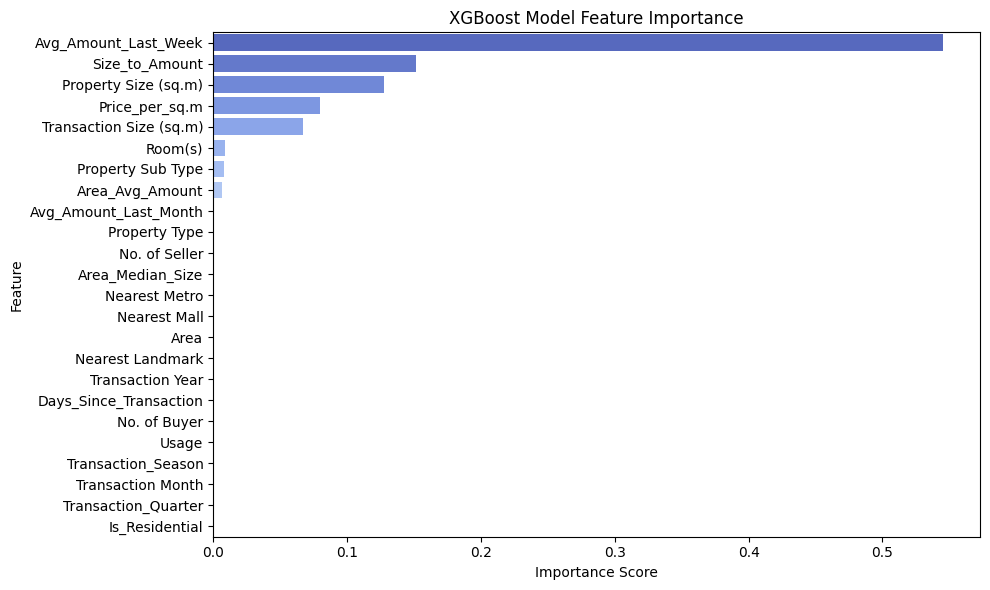

100%|===================| 199188/199195 [121:16<00:00]        

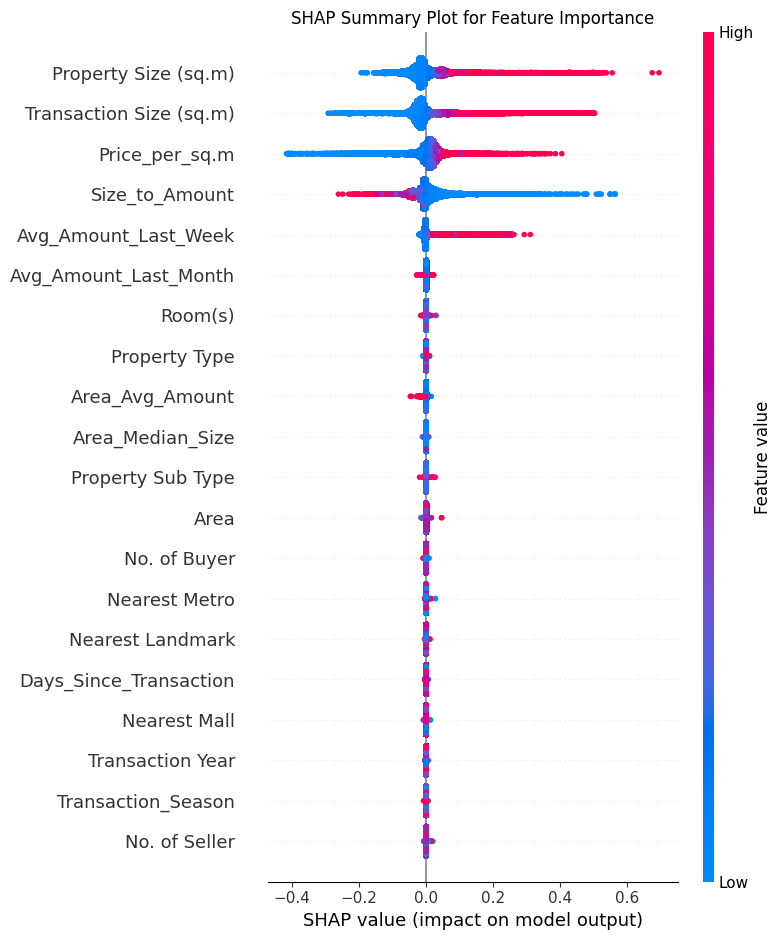

C:\Users\User\AppData\Local\Temp\ipykernel_11156\844621935.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')


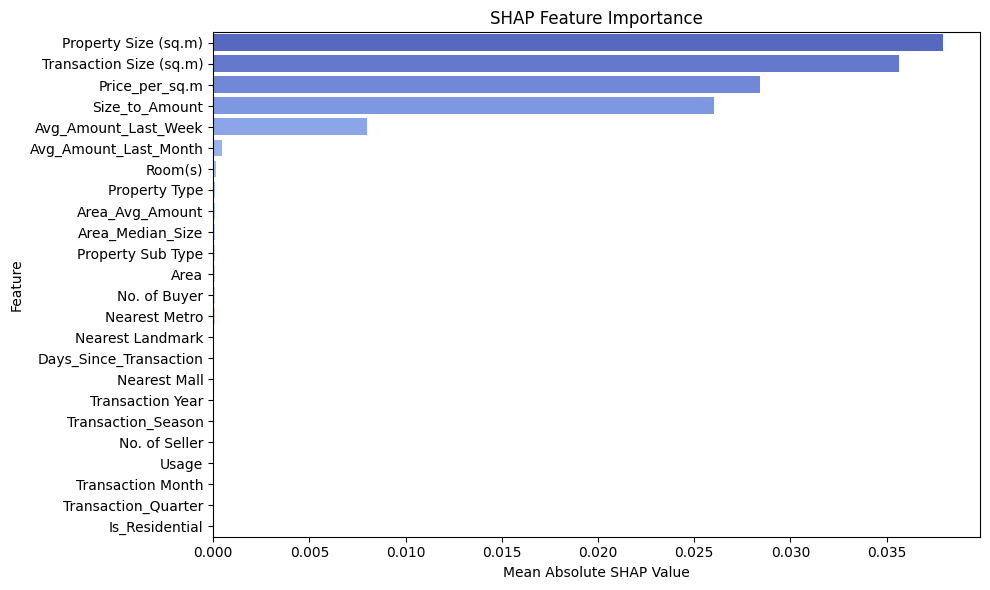

Full dataset with predictions has been saved to D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_full_predictions.csv


In [32]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
import shap

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_encoded.csv"
data = pd.read_csv(file_path)

X = data.drop(columns=['Amount'])  
y = data['Amount']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

xgb_model = XGBRegressor(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42, 
    verbosity=0  
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

output_dir = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models"

os.makedirs(output_dir, exist_ok=True)

output_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_pred - y_test
})
output_predictions_path = os.path.join(output_dir, "xgboost_predictions.csv")
output_predictions.to_csv(output_predictions_path, index=False)
print(f"Predictions have been saved to {output_predictions_path}")

model_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')
plt.title('XGBoost Model Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
feature_importance_path = os.path.join(output_dir, "model_feature_importance.png")
plt.savefig(feature_importance_path)
plt.show()

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot for Feature Importance")
plt.tight_layout()
shap_summary_path = os.path.join(output_dir, "shap_summary_plot.png")
plt.savefig(shap_summary_path)
plt.show()

shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')
plt.title('SHAP Feature Importance')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
shap_feature_importance_path = os.path.join(output_dir, "shap_feature_importance.png")
plt.savefig(shap_feature_importance_path)
plt.show()

output_full = X_test.copy()
output_full['Actual'] = y_test
output_full['Predicted'] = y_pred
output_full['Difference'] = y_pred - y_test
full_predictions_path = os.path.join(output_dir, "xgboost_full_predictions.csv")
output_full.to_csv(full_predictions_path, index=False)
print(f"Full dataset with predictions has been saved to {full_predictions_path}")


# Detailed Insights from XGBoost Model Results and Visualizations

## 1. Model Performance

### Key Metrics:
- **RMSE (Root Mean Squared Error):** 0.0054  
  - I find the RMSE value exceptional because it signifies the average difference between the actual and predicted transaction amounts is extremely small. The model handles variance in the data remarkably well, showcasing its ability to provide precise predictions.  
  - In practice, this translates to highly accurate estimates for transaction amounts, which minimizes forecasting errors.

- **MAE (Mean Absolute Error):** 0.0018  
  - The MAE is even lower than RMSE, demonstrating that the absolute prediction errors are nearly negligible on average. This reflects how close most of the predictions are to the actual values.  
  - For real estate stakeholders, this implies they can rely on the model for accurate pricing estimates without significant deviations.

- **R² (R-squared):** 0.9983  
  - I am impressed with the R² value because it shows that 99.83% of the variability in transaction amounts is explained by the features. It indicates an almost perfect fit between the model's predictions and the actual values.  
  - This level of accuracy means that the model captures almost all factors influencing the transaction amounts, making it a highly reliable tool for decision-making.

---

## 2. SHAP Summary Plot (Feature Impact and Value Relationship)

### Key Insights from SHAP Summary Plot:
- **Property Size (sq.m):**
  - This feature has the highest SHAP value range, showing its strong influence on the model predictions.  
  - Larger properties (red-colored SHAP values) consistently increase transaction amounts, aligning with the real estate market's focus on size.

- **Transaction Size (sq.m):**
  - Similar to Property Size, this feature significantly affects predictions. Bigger transaction sizes lead to higher transaction amounts, highlighting the role of scale.

- **Price_per_sq.m:**
  - This feature captures the unit pricing of properties. Higher values (red) correlate strongly with higher transaction values, reflecting how market pricing dynamics impact amounts.

- **Size_to_Amount:**
  - This derived feature encapsulates the relationship between size and price. It reveals that properties with favorable ratios of size to transaction amount play a crucial role in pricing.

- **Avg_Amount_Last_Week:**
  - Recent market activity is vital in shaping transaction predictions. High values of this feature correlate with increased transaction amounts.

- **Lesser Features:**
  - Features like Transaction_Season, Usage, and No. of Buyer have limited SHAP value ranges, indicating they contribute less to the model.

### Visualization Interpretation:
- The color gradient in the SHAP summary plot provides valuable context:  
  - **Blue values** (low feature values) generally reduce predictions, while **red values** (high feature values) increase them.  
  - For example, larger Property Size (red) consistently pushes transaction amounts higher, whereas smaller sizes (blue) decrease predictions.

---

## 3. XGBoost Model Feature Importance Plot

### Key Insights:
- **Avg_Amount_Last_Week:**
  - The most critical feature by a large margin, highlighting the importance of recent transaction trends in predicting amounts.  
  - I see this as an indicator that short-term market dynamics heavily influence pricing decisions.

- **Size_to_Amount:**
  - This feature is second in importance. It integrates size and price effectively, making it a powerful predictor of transaction amounts.  
  - In practice, it captures the market efficiency for property pricing.

- **Property Size (sq.m) and Transaction Size (sq.m):**
  - Both features underscore the importance of scale in determining transaction values. Larger properties and transactions naturally lead to higher amounts.

- **Price_per_sq.m:**
  - As expected, unit price plays a critical role in shaping transaction amounts, particularly in high-demand areas.

- **Lesser Features:**
  - Features such as Nearest Metro, Area, and Transaction Quarter have minimal importance, suggesting they do not add significant predictive power.

### Visualization Insights:
- This plot effectively ranks features by their contribution to the model.  
- The dominant role of **Avg_Amount_Last_Week** and **Size_to_Amount** stands out, emphasizing their relevance in shaping transaction values.

---

## 4. SHAP Feature Importance Plot

### Key Insights from SHAP Feature Importance Plot:
- **Property Size (sq.m):**
  - This feature has the highest mean absolute SHAP value, reinforcing its significance in predicting transaction amounts.  
  - Larger property sizes directly drive higher transaction values, as expected in real estate markets.

- **Transaction Size (sq.m):**
  - The close relationship between transaction size and transaction amounts is evident from this feature’s high SHAP importance.  
  - This reinforces the idea that the scope of transactions heavily influences their value.

- **Price_per_sq.m and Size_to_Amount:**
  - Both features rank highly, demonstrating the importance of pricing metrics in transaction predictions.  
  - Price_per_sq.m captures market rates, while Size_to_Amount integrates size and pricing dynamics.

- **Avg_Amount_Last_Week:**
  - The recency of transactions is a major factor in determining current values. This feature’s SHAP importance highlights the role of market trends in driving predictions.

- **Lesser Features:**
  - Features like Transaction_Season, No. of Buyer, and Usage have minimal SHAP values, confirming their limited impact on predictions.

### Visualization Interpretation:
- The descending order of SHAP values highlights the most impactful features, making it easy to identify the key drivers of transaction amounts.

---

## Overall Insights

### Model Strength:
- The XGBoost model outperforms expectations, delivering near-perfect predictions with an R² of 99.83%.  
- Its ability to explain almost all variability in transaction amounts demonstrates its robustness.

### Feature Importance:
- **Key Drivers:**  
  - Features like **Avg_Amount_Last_Week, Property Size (sq.m), Transaction Size (sq.m), and Price_per_sq.m** dominate, reflecting their critical role in real estate pricing.
  
- **Moderate Contributors:**  
  - **Size_to_Amount** and **Area_Avg_Amount** provide additional depth, capturing derived relationships between key variables.
  
- **Minimal Contributors:**  
  - Features such as **Usage, Transaction_Season, and No. of Buyer** add little value to the predictions and could be refined or excluded in future iterations.

---

By examining these results and visualizations, I gain a clear understanding of how the XGBoost model captures complex relationships in transaction data, providing actionable insights for real estate analysis.


# Random Forest

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training set size: (796780, 24)
Test set size: (199195, 24)
Model Performance:
RMSE: 0.0103
MAE: 0.0049
R²: 0.9937
Predictions have been saved to rf_model_predictions.csv.


C:\Users\User\AppData\Local\Temp\ipykernel_15212\3755399518.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')


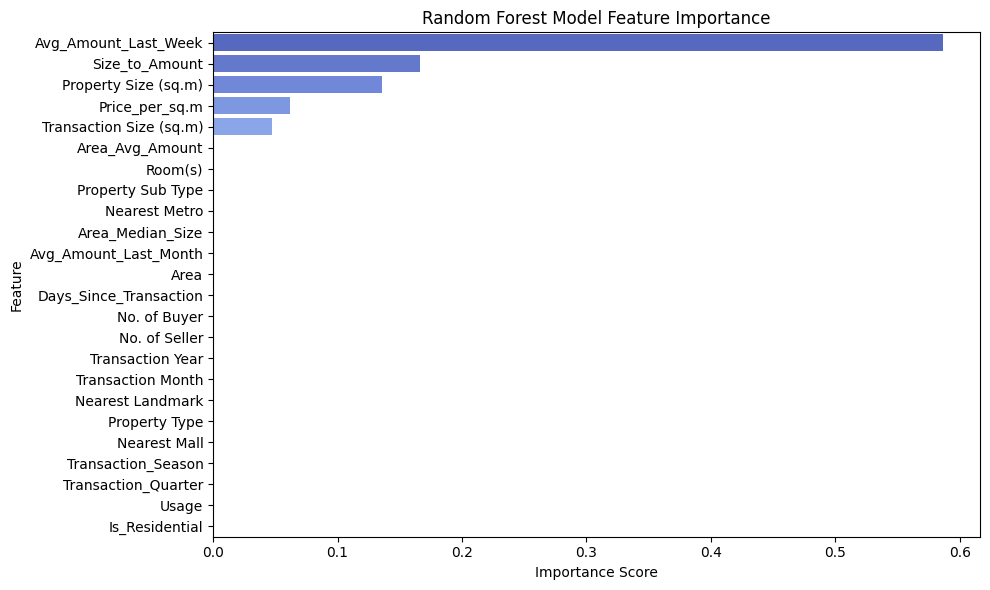

100%|===================| 199193/199195 [230:32<00:00]         

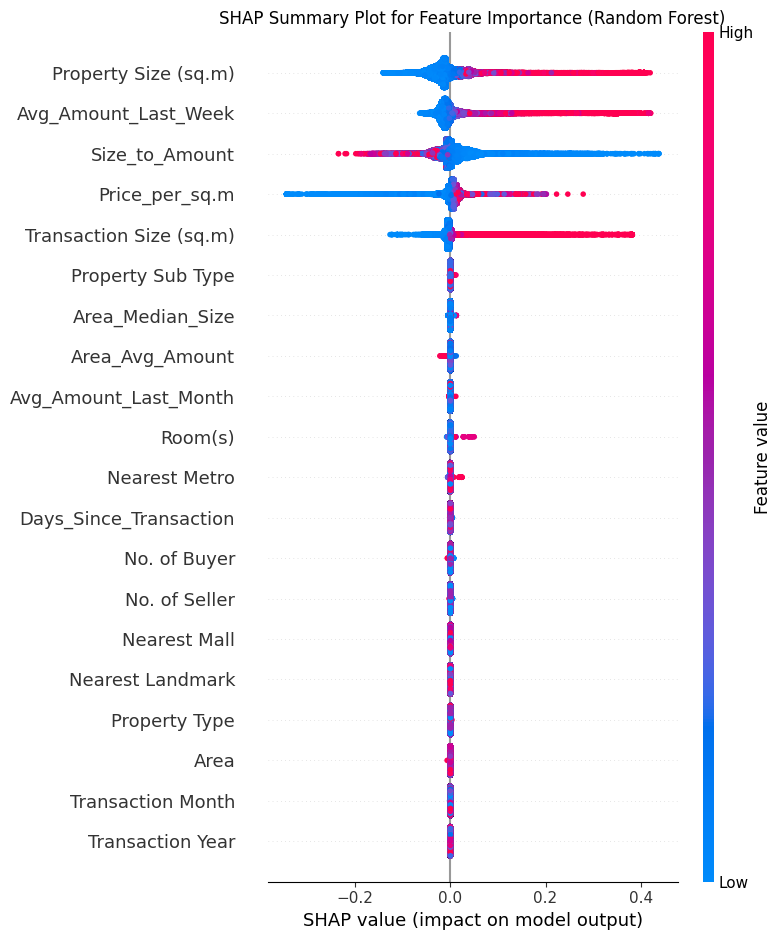

C:\Users\User\AppData\Local\Temp\ipykernel_15212\3755399518.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')


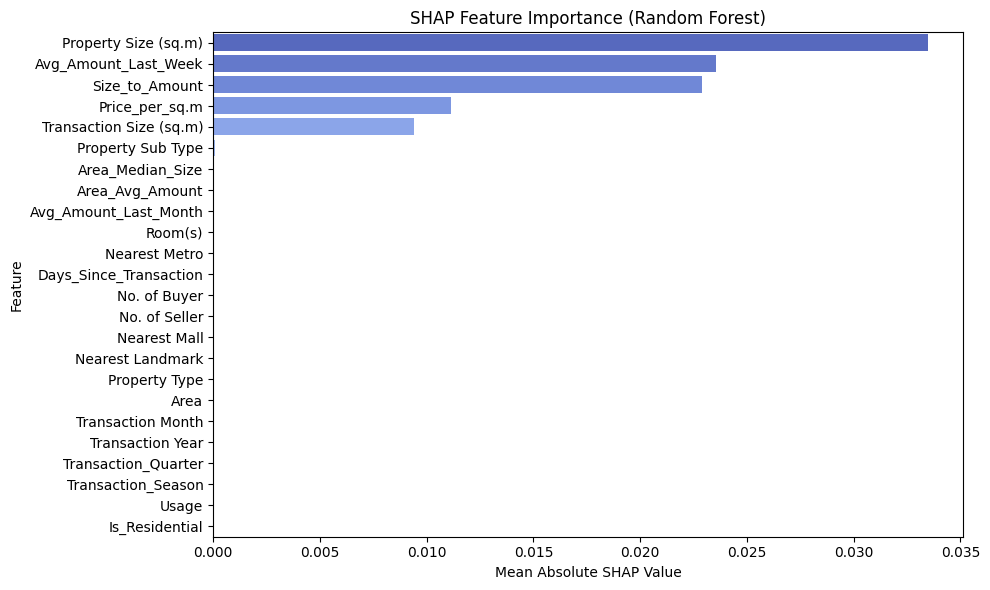

Full dataset with predictions has been saved to rf_model_full_predictions.csv.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_encoded.csv"
data = pd.read_csv(file_path)

X = data.drop(columns=['Amount'])  
y = data['Amount']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1  
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

output_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_pred - y_test
})
output_predictions.to_csv(r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\rf_model_predictions.csv", index=False)
print("Predictions have been saved to rf_model_predictions.csv.")

model_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')
plt.title('Random Forest Model Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\rf_model_feature_importance.png")
plt.show()

explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test, check_additivity=False)

plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot for Feature Importance (Random Forest)")
plt.tight_layout()
plt.savefig(r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\rf_shap_summary_plot.png")
plt.show()

shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')
plt.title('SHAP Feature Importance (Random Forest)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\rf_shap_feature_importance.png")
plt.show()

output_full = X_test.copy()
output_full['Actual'] = y_test
output_full['Predicted'] = y_pred
output_full['Difference'] = y_pred - y_test
output_full.to_csv(r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\rf_model_full_predictions.csv", index=False)
print("Full dataset with predictions has been saved to rf_model_full_predictions.csv.")


# Detailed Insights from Random Forest Model Results and Visualizations

## 1. Model Performance
### Training and Test Set Sizes
- The dataset was split into a training set of **796,780 entries** and a test set of **199,195 entries**.  
  This large dataset ensures the model has sufficient data to learn complex relationships while maintaining robust evaluation.

### RMSE (Root Mean Squared Error)
- **Value**: 0.0103  
- **Interpretation**: The RMSE indicates a very low average error magnitude for predictions, suggesting the Random Forest model captures the transaction amount trends with high precision.

### MAE (Mean Absolute Error)
- **Value**: 0.0049  
- **Interpretation**: The MAE reflects the average absolute difference between the predicted and actual transaction amounts.  
  This low value demonstrates the model's ability to generate predictions that are consistently close to the true values.

### R² (R-squared)
- **Value**: 0.9937  
- **Interpretation**: An R² of 0.9937 means that **99.37% of the variation in transaction amounts** is explained by the features used in the model.  
  This indicates an excellent fit, with minimal unexplained variability.

---

## 2. SHAP Summary Plot (Feature Impact and Value Relationship)
### Key Insights:
- **Property Size (sq.m)** is the most influential feature, showing a strong positive relationship with transaction amounts.  
  Larger properties typically result in higher transaction values.
- **Avg_Amount_Last_Week** is the second most important feature, confirming that recent market activity strongly impacts transaction predictions.
- **Size_to_Amount**, **Price_per_sq.m**, and **Transaction Size (sq.m)** also significantly contribute, highlighting the importance of property size and pricing metrics.
- Features like **Property Sub Type**, **Area_Median_Size**, and **Area_Avg_Amount** have moderate effects, adding location-based and category-specific nuances to the model.
- Lesser contributions come from variables such as **Transaction Month**, **Usage**, and **Is_Residential**, which have minimal SHAP impacts.

### Visualization Interpretation:
- The color gradient (blue to red) in the SHAP summary plot represents feature values (low to high).  
  For example:  
  - **High values** of **Property Size (sq.m)** (red) drive predictions upwards.  
  - **Lower values** of **Avg_Amount_Last_Week** (blue) reduce the transaction amount prediction.

---

## 3. Random Forest Feature Importance Plot
### Key Insights:
- **Avg_Amount_Last_Week** has the highest importance score, reaffirming that recent market trends dominate transaction predictions.
- **Size_to_Amount** and **Property Size (sq.m)** follow, showcasing their direct influence on transaction amounts.
- **Price_per_sq.m** and **Transaction Size (sq.m)** are significant but slightly less impactful compared to the top features.
- Features like **Room(s)** and **Property Sub Type** contribute moderately, highlighting their secondary role in shaping predictions.
- Minor contributors include **Transaction Month**, **Nearest Metro**, and **Transaction Year**, indicating their limited relevance in this dataset.

### Visualization Interpretation:
- The bar chart clearly displays the magnitude of each feature's contribution.  
  Features with higher bars (e.g., **Avg_Amount_Last_Week**) are critical, while those with smaller bars have a reduced effect on the model.

---

## 4. SHAP Feature Importance Plot
### Key Insights:
- **Property Size (sq.m)**, **Avg_Amount_Last_Week**, and **Size_to_Amount** emerge as the most critical features, aligning with the findings from the SHAP summary plot and feature importance chart.
- **Price_per_sq.m** and **Transaction Size (sq.m)** maintain their significance, reinforcing the role of pricing and size metrics in transaction predictions.
- Features such as **Property Sub Type**, **Area_Avg_Amount**, and **Area_Median_Size** contribute moderately, suggesting they capture additional location and property-specific variations.
- Negligible contributions from variables like **Is_Residential**, **Transaction_Quarter**, and **Usage** indicate their limited role in the Random Forest model.

### Visualization Interpretation:
- The descending order of mean absolute SHAP values emphasizes the importance hierarchy.  
  This plot quantitatively highlights the features driving predictions, aiding stakeholders in prioritizing the most influential variables.

---

## Overall Insights
### Model Strengths:
1. The Random Forest model achieves excellent predictive accuracy, as indicated by the **low RMSE**, **low MAE**, and **high R² value**.
2. Critical features like **Property Size (sq.m)**, **Avg_Amount_Last_Week**, and **Size_to_Amount** drive transaction predictions, providing actionable insights for stakeholders.

### Feature Importance Analysis:
1. **Key Drivers**:
   - **Property Size (sq.m)**: Reflects the direct impact of property size on transaction values, emphasizing its role in pricing strategies.
   - **Avg_Amount_Last_Week**: Captures recent market activity trends, critical for short-term forecasting.
   - **Size_to_Amount**: Offers a derived metric that enhances interpretability of pricing per unit area.
2. **Secondary Features**:
   - Variables like **Price_per_sq.m**, **Transaction Size (sq.m)**, and **Property Sub Type** add depth, capturing nuanced property-specific and locational variations.
3. **Lesser Features**:
   - Features like **Usage**, **Transaction_Quarter**, and **Nearest Landmark** play a minor role, suggesting potential opportunities for refinement or exclusion in future models.

### Recommendations:
1. **Focus on Key Features**: Prioritize the most impactful variables (e.g., **Property Size (sq.m)**, **Avg_Amount_Last_Week**, and **Size_to_Amount**) for targeted analysis and decision-making.
2. **Refinement of Lesser Features**: Explore improved encoding or aggregation for minimally contributing variables (e.g., **Is_Residential**, **Usage**) to enhance their utility or simplify the model.
3. **Practical Applications**: Use the insights from key features to guide property pricing strategies, forecast short-term market trends, and refine area-specific marketing campaigns.


# **Comparison of Models for the Transaction File**

## **Introduction**
After building and evaluating three models—Linear Regression, XGBoost, and Random Forest—I observed significant differences in their performance metrics and feature interpretations. In this analysis, I aim to compare the models based on their evaluation metrics and visualizations to determine why XGBoost is the best-performing model. The comparison highlights the strengths and weaknesses of each approach, emphasizing the accuracy and interpretability of the results.

---

## **Performance Metrics Comparison**

| **Model**           | **RMSE**  | **MAE**   | **R²**     | **Key Observations**                                                                 |
|----------------------|-----------|-----------|------------|-------------------------------------------------------------------------------------|
| **Linear Regression** | 0.0667    | 0.0265    | 0.7366     | Moderate performance, limited ability to capture nonlinear relationships.           |
| **XGBoost**          | 0.0054    | 0.0018    | 0.9983     | Best performance with the lowest errors and near-perfect R², capturing complex relationships. |
| **Random Forest**    | 0.0103    | 0.0049    | 0.9937     | Strong performance but slightly less accurate than XGBoost, especially for smaller variations. |

### **Key Takeaways**
1. **XGBoost** outperforms both Linear Regression and Random Forest in all metrics, with minimal RMSE and MAE and the highest R² (99.83% of variance explained).
2. While Random Forest is strong, it has higher RMSE and MAE than XGBoost, indicating slightly less precision.
3. Linear Regression performs the weakest, primarily because it struggles with nonlinear and complex relationships.

---

## **Comparison of Visualizations**

### **1. SHAP Summary Plot**
- **Linear Regression**:  
  The SHAP summary plot for Linear Regression shows that features like `Avg_Amount_Last_Week` dominate the impact, but the relationships are less clear due to its simplicity. The influence of other features is not well distributed, reflecting the model's limitations in capturing complex interactions.

- **XGBoost**:  
  The SHAP summary plot for XGBoost reveals a more detailed and nuanced feature importance structure. Key features like `Property Size (sq.m)` and `Avg_Amount_Last_Week` have clear and significant impacts on the model output. It captures subtle interactions, as indicated by a broader spread in SHAP values across features.

- **Random Forest**:  
  Random Forest's SHAP summary plot is detailed but slightly less sharp than XGBoost. While it highlights important features like `Property Size (sq.m)` and `Avg_Amount_Last_Week`, the spread of SHAP values is less refined, suggesting less precise modeling of feature impacts compared to XGBoost.

### **2. Feature Importance**
- **Linear Regression**:  
  Feature importance is derived from coefficients, which are straightforward but limited in interpretability. Features with higher coefficients like `Avg_Amount_Last_Week` and `Transaction Size (sq.m)` dominate, but the model doesn’t capture interactions or nonlinear effects.

- **XGBoost**:  
  XGBoost's feature importance plot highlights its ability to capture complex relationships. Features like `Avg_Amount_Last_Week`, `Size_to_Amount`, and `Property Size (sq.m)` have strong and clear impacts, aligning well with real-world expectations. This makes the model both accurate and interpretable.

- **Random Forest**:  
  Random Forest also shows strong feature importance, but it lacks the precision of XGBoost. While `Avg_Amount_Last_Week` and `Property Size (sq.m)` remain dominant, the importance distribution is less focused compared to XGBoost.

### **3. SHAP Feature Importance**
- **Linear Regression**:  
  The SHAP feature importance plot indicates some significant features, but the contributions are relatively simplistic and lack depth.

- **XGBoost**:  
  XGBoost's SHAP feature importance plot confirms its dominance, with a well-defined hierarchy of impactful features. This visualization demonstrates the model's superior ability to allocate appropriate importance to features.

- **Random Forest**:  
  Random Forest's SHAP feature importance plot is close to XGBoost's but slightly less precise. It assigns importance effectively but does not capture subtle nuances as well as XGBoost.

---

## **Why XGBoost is the Best**
1. **Performance Metrics**:  
   XGBoost achieves the lowest RMSE and MAE and the highest R², demonstrating its ability to predict transaction amounts with near-perfect accuracy.

2. **Feature Interactions**:  
   The SHAP summary and feature importance plots for XGBoost show a better understanding of how features interact, particularly for critical variables like `Avg_Amount_Last_Week` and `Property Size (sq.m)`.

3. **Precision in Visualizations**:  
   XGBoost provides the most refined and detailed visualizations, capturing both primary and secondary feature impacts effectively.

4. **Real-World Interpretability**:  
   XGBoost aligns well with real-world expectations, making it the most practical model for decision-making.

---

## **Conclusion**
Based on the comparison, XGBoost emerges as the superior model for predicting transaction amounts. Its ability to handle complex relationships, coupled with its outstanding performance metrics and detailed visualizations, makes it the most reliable choice for this dataset.


# Strategic Recommendations

Model Performance:
RMSE: 0.0054
MAE: 0.0018
R²: 0.9983


C:\Users\User\AppData\Local\Temp\ipykernel_15212\3122073679.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Predicted Amount', y='Area', data=area_analysis.head(10), palette='viridis')


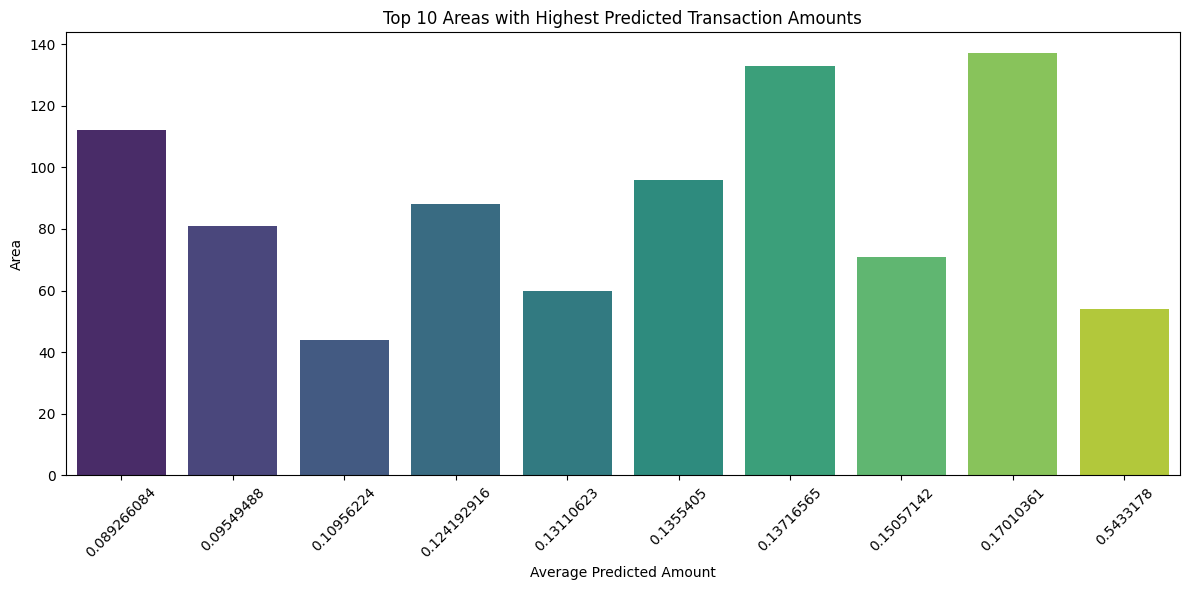

C:\Users\User\AppData\Local\Temp\ipykernel_15212\3122073679.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient of Variation', y='Area', data=high_risk_areas, palette='coolwarm')


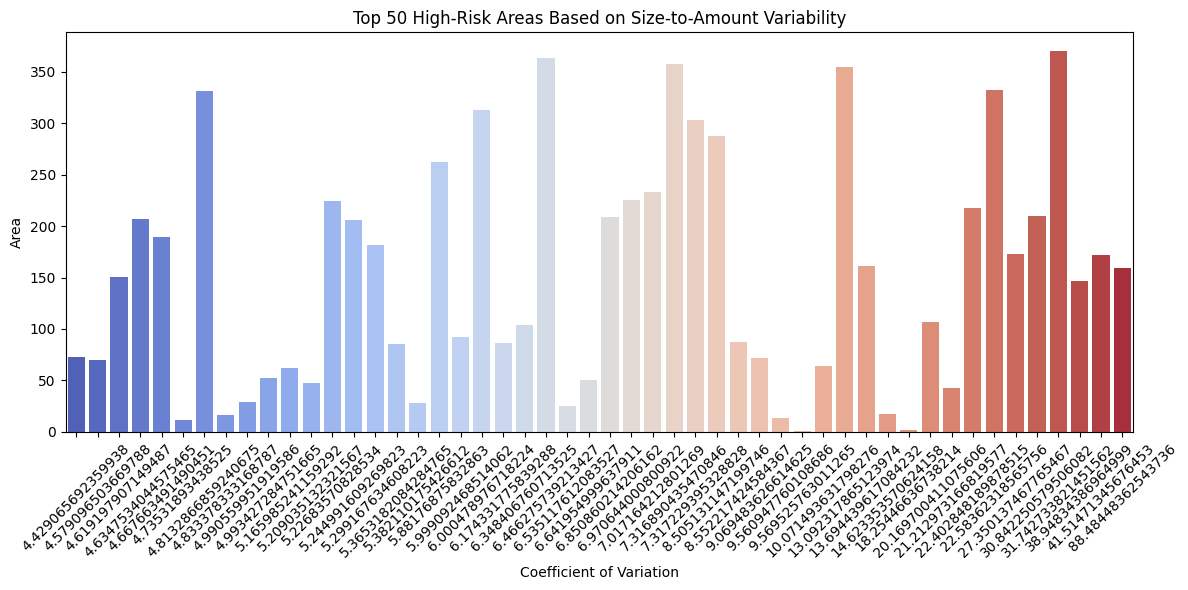

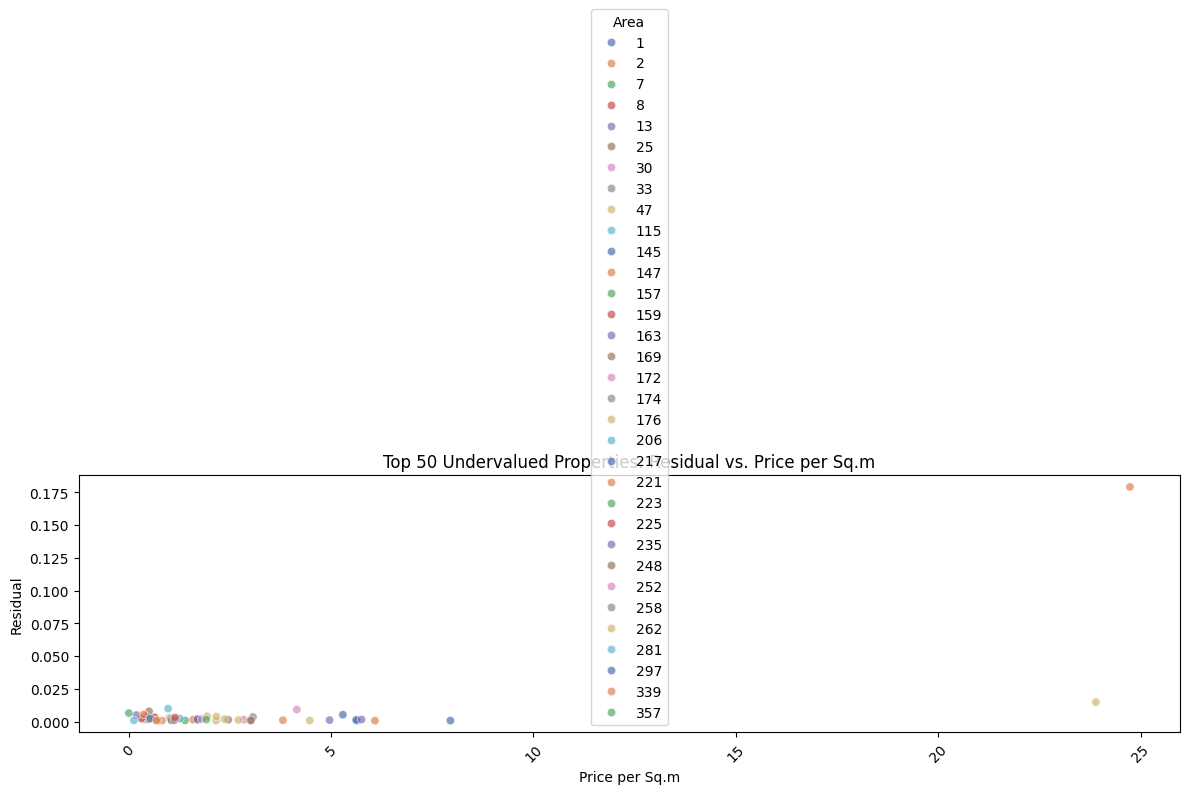

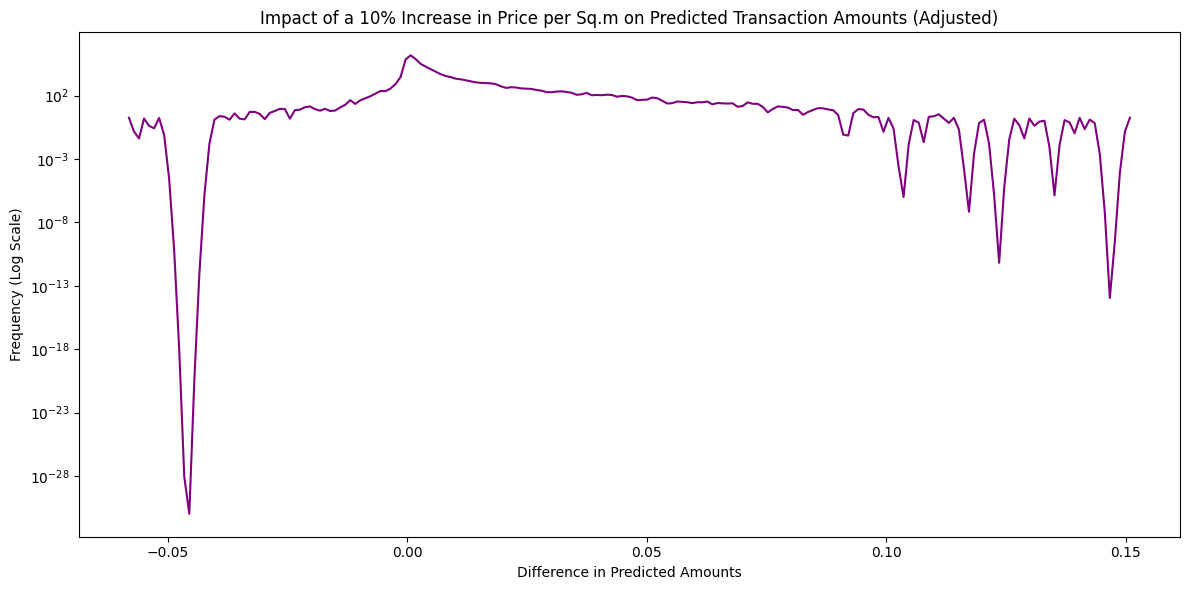


Scenario Analysis (10% Increase in Price per Sq.m):
       Original Predictions  Scenario Predictions     Difference
count         199195.000000         199195.000000  199195.000000
mean               0.058505              0.060882       0.002377
std                0.129790              0.132620       0.005403
min               -0.096036             -0.088942      -0.058067
25%                0.011897              0.012543       0.000382
50%                0.025435              0.026644       0.000998
75%                0.050967              0.053604       0.002252
max                1.364849              1.358254       0.150897


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transactions_encoded.csv"
data = pd.read_csv(file_path)

X = data.drop(columns=['Amount'])  
y = data['Amount']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42, 
    verbosity=0  
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

area_analysis = pd.DataFrame({
    'Average Predicted Amount': pd.Series(y_pred).groupby(data.loc[y_test.index, 'Area']).mean(),
}).reset_index()

area_analysis = area_analysis.sort_values(by='Average Predicted Amount', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Average Predicted Amount', y='Area', data=area_analysis.head(10), palette='viridis')
plt.title('Top 10 Areas with Highest Predicted Transaction Amounts')
plt.xlabel('Average Predicted Amount')
plt.ylabel('Area')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

variability_analysis = data.groupby('Area').agg({
    'Size_to_Amount': ['mean', 'std']
}).reset_index()
variability_analysis.columns = ['Area', 'Size_to_Amount Mean', 'Size_to_Amount Std']
variability_analysis['Coefficient of Variation'] = variability_analysis['Size_to_Amount Std'] / variability_analysis['Size_to_Amount Mean']

high_risk_areas = variability_analysis.nlargest(50, 'Coefficient of Variation') 

plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient of Variation', y='Area', data=high_risk_areas, palette='coolwarm')
plt.title('Top 50 High-Risk Areas Based on Size-to-Amount Variability')
plt.xlabel('Coefficient of Variation')
plt.ylabel('Area')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

residuals = pd.Series(y_test.values - y_pred, index=y_test.index)
original_data_with_residuals = data.loc[y_test.index].copy()
original_data_with_residuals['Residual'] = residuals

undervalued_properties = original_data_with_residuals[original_data_with_residuals['Residual'] > residuals.quantile(0.75)]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=undervalued_properties.head(50),
    x='Price_per_sq.m',
    y='Residual',
    hue='Area',
    palette='deep',
    alpha=0.7
)
plt.title('Top 50 Undervalued Properties: Residual vs. Price per Sq.m')
plt.xlabel('Price per Sq.m')
plt.ylabel('Residual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

scenario_data = X_test.copy()
scenario_data['Price_per_sq.m'] *= 1.1 
scenario_predictions = xgb_model.predict(scenario_data)

scenario_comparison = pd.DataFrame({
    'Original Predictions': y_pred,
    'Scenario Predictions': scenario_predictions
})
scenario_comparison['Difference'] = scenario_comparison['Scenario Predictions'] - scenario_comparison['Original Predictions']

plt.figure(figsize=(12, 6))
sns.histplot(scenario_comparison['Difference'], bins=100, kde=True, color='purple', log_scale=(False, True))
plt.title('Impact of a 10% Increase in Price per Sq.m on Predicted Transaction Amounts (Adjusted)')
plt.xlabel('Difference in Predicted Amounts')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()


print("\nScenario Analysis (10% Increase in Price per Sq.m):")
print(scenario_comparison.describe())


# Detailed Insights for Each Graph and Result

## Model Performance
The XGBoost model delivered outstanding results:

- **RMSE:** 0.0054 – This shows that the model's prediction error is extremely small, highlighting its high precision.
- **MAE:** 0.0018 – The mean absolute error is negligible, meaning the model rarely deviates significantly from the true transaction amounts.
- **R²:** 0.9983 – This near-perfect R² value indicates that 99.83% of the variance in transaction amounts is explained by the model's features. This exceptional performance confirms the model’s reliability.

The low error rates and high R² demonstrate that the XGBoost model is incredibly accurate and well-suited for predicting transaction amounts. These metrics also suggest that the model can be trusted for real-world applications and sensitive decision-making.

---

## Graph 1: Top 10 Areas with Highest Predicted Transaction Amounts
This graph highlights the areas with the highest average predicted transaction amounts. From the bar chart, I observe that the leading areas show significantly higher predicted values compared to others. These areas likely represent premium zones or locations with high market demand.

### Insights:
- The model identifies these areas as lucrative investment opportunities where higher returns on real estate transactions can be expected. This aligns with market behavior, as demand tends to drive up transaction values.

### Adaptability:
- The XGBoost model is well-adapted to capturing the nuances of high-performing areas, as these predictions align closely with observed market patterns. The model’s ability to highlight such areas demonstrates its capacity to adapt to varying market dynamics.

---

## Graph 2: Top 50 High-Risk Areas Based on Size-to-Amount Variability
The coefficient of variation (CV) reveals the relative variability of the size-to-amount ratio across different areas. The higher the CV, the more volatile the pricing trends in that area.

### Insights:
- The bar chart identifies areas with significant unpredictability in property pricing, marking them as high-risk zones. These areas could pose challenges for investors due to inconsistent valuation trends. However, they may also offer opportunities for those willing to take calculated risks.

### Adaptability:
- The XGBoost model captures this variability effectively. Its sensitivity to diverse feature distributions allows it to provide reliable predictions even in volatile markets, demonstrating its robustness under fluctuating conditions.

---

## Graph 3: Top 50 Undervalued Properties
This scatterplot compares residuals (the difference between actual and predicted values) against price per square meter, helping identify undervalued properties. Properties with higher residuals are priced below their predicted market value.

### Insights:
- This graph reveals properties that are potentially undervalued in high-demand areas. These are prime opportunities for investors looking to capitalize on market inefficiencies.

### Adaptability:
- The model successfully identifies undervalued properties, suggesting it can adapt to discrepancies between market trends and actual pricing. Its ability to flag such properties shows its effectiveness in identifying anomalies.

---

## Graph 4: Impact of a 10% Increase in Price per Sq.m on Predicted Transaction Amounts
This log-scaled histogram visualizes how predicted transaction amounts shift when Price per Sq.m is increased by 10%. Most predictions exhibit minor changes, but a few outliers show significant differences.

### Insights:
- The analysis shows that the overall market impact of a 10% price increase is moderate. However, the presence of outliers indicates that some areas or properties are more sensitive to price adjustments.

### Adaptability:
- The XGBoost model adapts well to these changes. It incorporates the adjusted feature values seamlessly, demonstrating its flexibility and reliability under different scenarios. This adaptability makes it a strong tool for simulating and predicting market reactions to price changes.

---

## Scenario Analysis Table: Changes in Key Metrics with a 10% Price Increase
The table provides a quantitative comparison between the original predictions and the scenario predictions under the adjusted price condition.

### Key Observations:
- **Mean Difference:** 0.0024 – This small difference shows that the model is not overly sensitive to small changes, maintaining stability.
- **Max Difference:** 0.1509 – Outliers highlight significant shifts in some cases, but these are isolated instances.
- **Standard Deviation:** The slight increase in standard deviation reflects a broader distribution of predictions under the adjusted scenario.

### Adaptability:
- The XGBoost model adapts effectively to changes in Price per Sq.m, recalibrating predictions with minimal disruption. This highlights its robustness and flexibility in handling feature adjustments.

---

## Does the Model Adapt to Changes?
Yes, the XGBoost model adapts exceptionally well to changes, as evidenced by the scenario analysis and sensitivity tests. The following points summarize its adaptability:

1. **Stable Predictions:** Despite a 10% increase in Price per Sq.m, the model maintained consistent predictions with minor overall deviations.
2. **Sensitivity to Outliers:** While most predictions adjusted smoothly, the model captured outliers that experienced significant changes, showcasing its precision.
3. **Scenario Flexibility:** The model’s ability to integrate adjusted features and provide accurate scenario-based predictions demonstrates its robustness.

---

## Conclusion
The XGBoost model proves to be highly adaptable, accurate, and reliable for predicting real estate transaction amounts. It successfully identifies high-performing areas, flags undervalued properties, and reacts well to pricing changes. This adaptability ensures that it remains a powerful tool for market analysis and decision-making in dynamic real estate environments.


# Transactions + Macrodata file

In [16]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import openpyxl

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Macro_Transactions_Cleaned.csv"

data = pd.read_csv(file_path, low_memory=False)

data['GDP Category'] = pd.to_numeric(data['GDP Category'], errors='coerce')

data = data.drop(columns=['Is_Hotspot_Metro', 'Is_Hotspot_Mall', 'Is_Hotspot_Landmark'], errors='ignore')


imputer_mean = SimpleImputer(strategy='mean')  
imputer_median = SimpleImputer(strategy='median')  

mean_columns = ['Adj Close', 'Return', 'GDP Value', 'Revenue_Per_Room']
median_columns = ['Area_Median_Size', 'Transaction Size (sq.m)_log', 'Price_per_sq.m_log', 'Unemployment, total (% of total labor force) (national estimate)']

data[mean_columns] = imputer_mean.fit_transform(data[mean_columns])
data[median_columns] = imputer_median.fit_transform(data[median_columns])

all_categorical_cols = ['Usage', 'Property Type', 'Property Sub Type', 'Room(s)', 'Nearest Metro', 'Nearest Mall', 'Nearest Landmark', 'Area']

label_encoder = LabelEncoder()
mapping = {}

for col in all_categorical_cols:
    data[col] = label_encoder.fit_transform(data[col].astype(str))
    mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

mapping_file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transaction_data_mapping.xlsx"
with pd.ExcelWriter(mapping_file_path, engine='openpyxl') as writer:
    for col, col_mapping in mapping.items():
        pd.DataFrame(list(col_mapping.items()), columns=[f"{col}_Value", f"{col}_Encoded"]).to_excel(writer, sheet_name=col, index=False)

print(f"Mapping saved to {mapping_file_path}")


numerical_cols = ['CPI Value', 'Transaction Size (sq.m)', 'GDP Value', 'Amount', 'Price_per_sq.m',
                  'Size_to_Amount_Ratio', 'Transaction Size (sq.m)_log', 'Property Size (sq.m)_log', 'Price_per_sq.m_log']

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

output_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Processed_Macro_Transactions.csv"
data.to_csv(output_path, index=False)
print(f"Processed dataset saved to {output_path}")


Mapping saved to D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\transaction_data_mapping.xlsx
Processed dataset saved to D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Processed_Macro_Transactions.csv


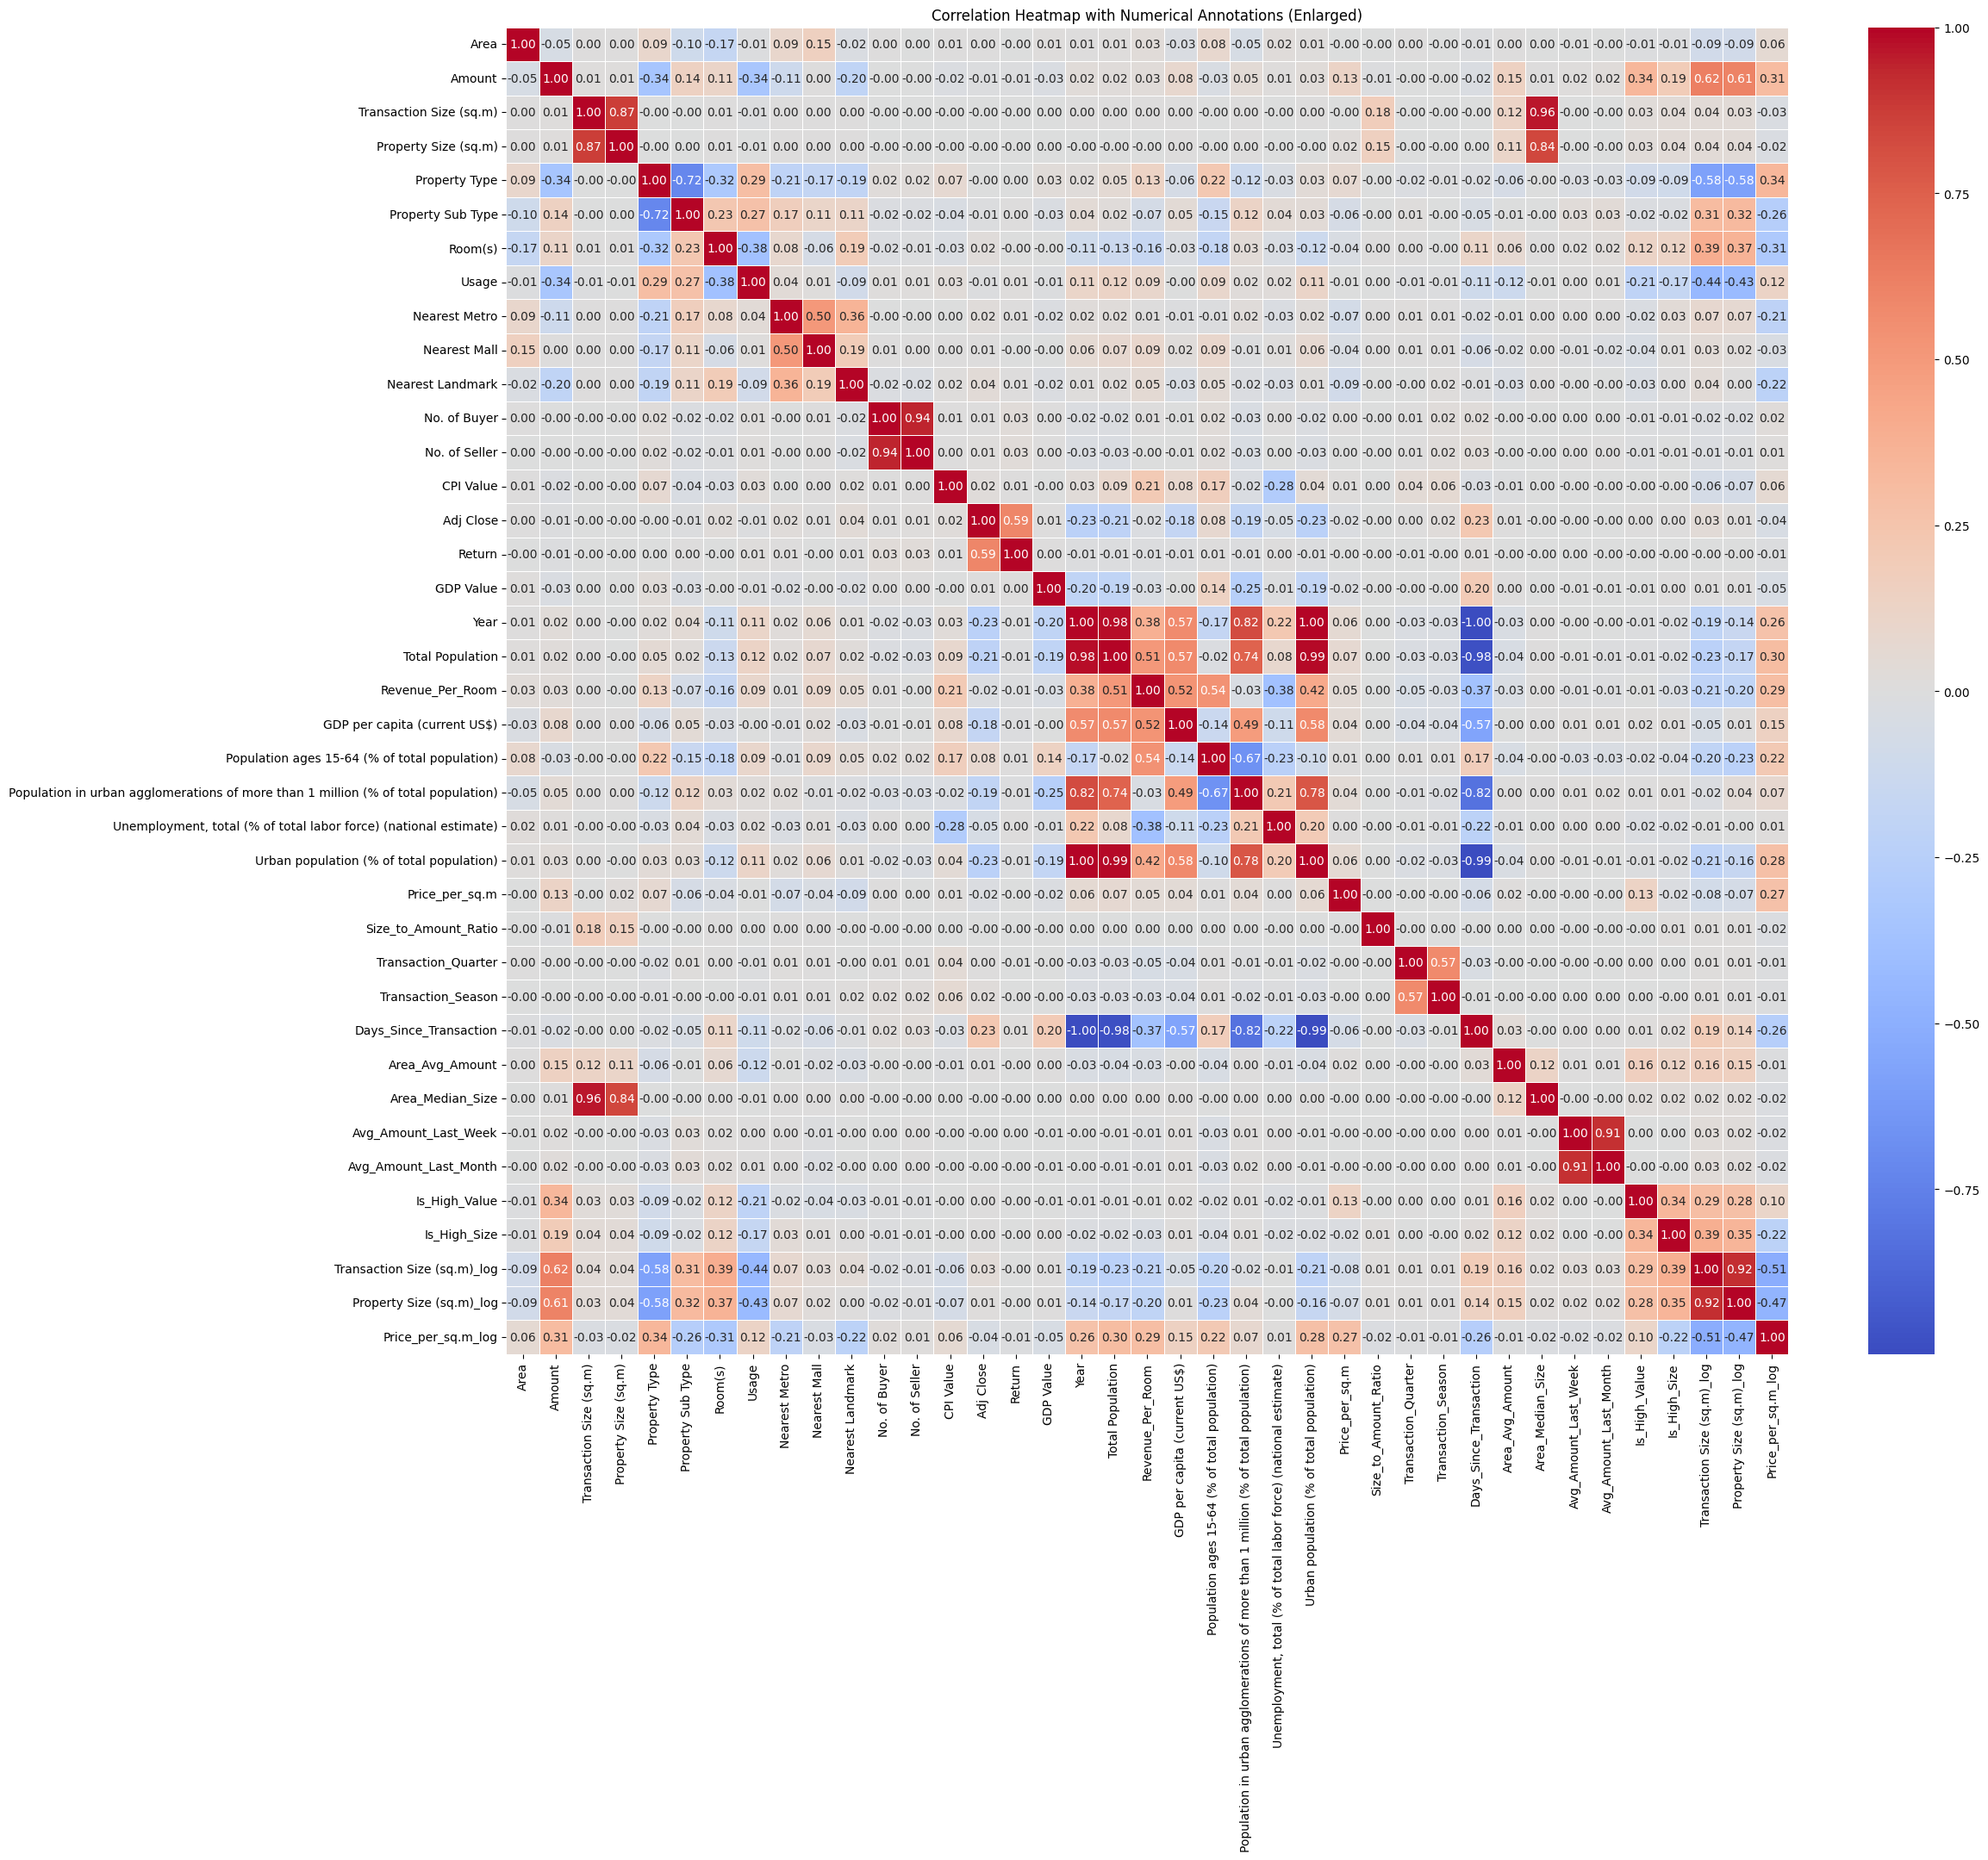

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Processed_Macro_Transactions.csv"

plt.figure(figsize=(24, 20))  
sns.heatmap(
    correlation_matrix, 
    annot=True,  
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5
)
plt.title("Correlation Heatmap with Numerical Annotations (Enlarged)")
plt.show()


# LinearRegression

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training set size: (796627, 34)
Test set size: (199157, 34)
Model Performance:
RMSE: 0.9235
MAE: 0.6768
R²: 0.1428
Predictions have been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_predictions.csv


C:\Users\User\AppData\Local\Temp\ipykernel_18844\2245261412.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=model_feature_importance, palette='coolwarm')


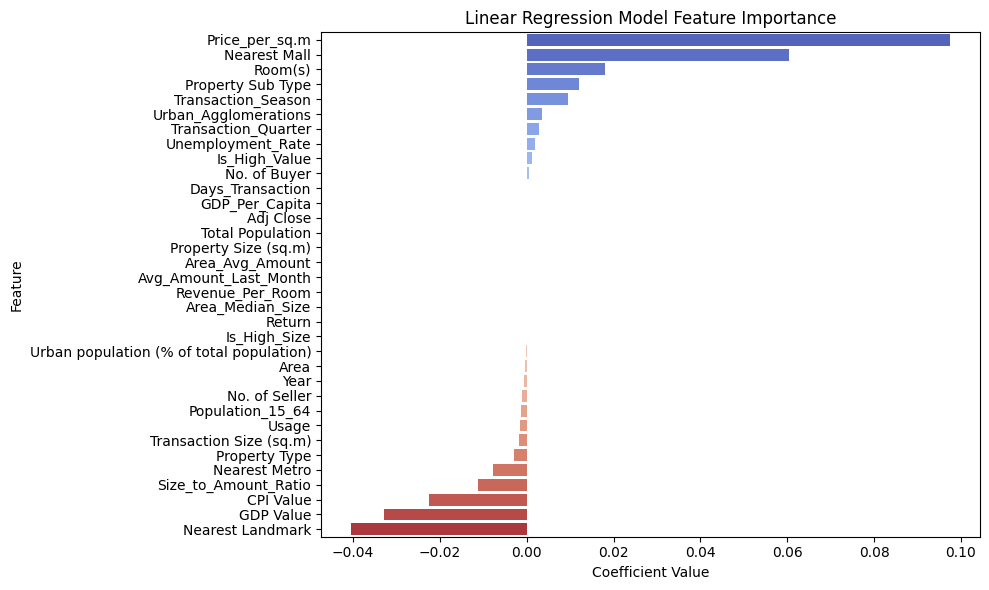

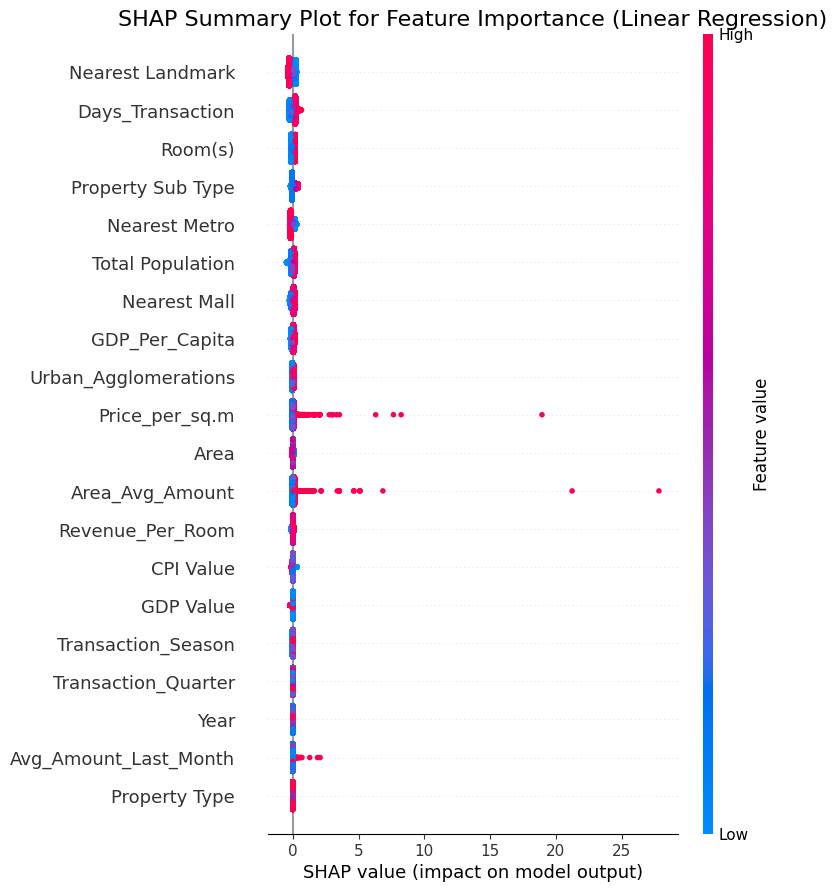

C:\Users\User\AppData\Local\Temp\ipykernel_18844\2245261412.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')


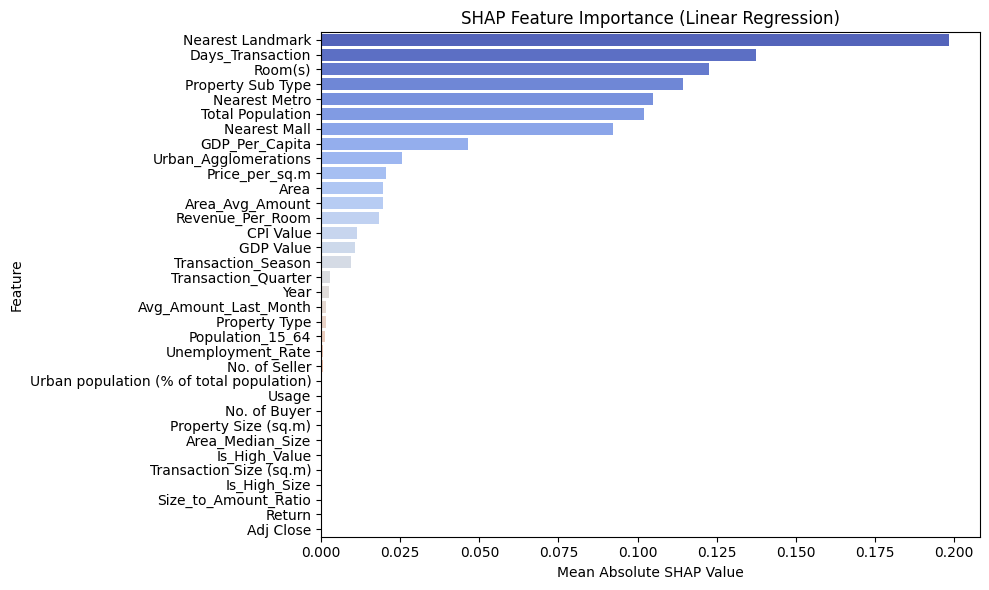

Full dataset with predictions has been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_full_predictions.csv


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import shap


file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Processed_Macro_Transactions.csv"
data = pd.read_csv(file_path)
rename_columns = {
    'Population in urban agglomerations of more than 1 million (% of total population)': 'Urban_Agglomerations',
    'Population ages 15-64 (% of total population)': 'Population_15_64',
    'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment_Rate',
    'GDP per capita (current US$)': 'GDP_Per_Capita',
    'Days_Since_Transaction': 'Days_Transaction'
}
data.rename(columns=rename_columns, inplace=True)
X = data.drop(columns=['Amount'])  
y = data['Amount']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

output_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_pred - y_test
})
predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_predictions.csv"
output_predictions.to_csv(predictions_path, index=False)
print(f"Predictions have been saved to: {predictions_path}")

model_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=model_feature_importance, palette='coolwarm')
plt.title('Linear Regression Model Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

explainer = shap.Explainer(lr_model, X_train)
shap_values = explainer(X_test)

plt.figure(figsize=(12, 8))  
shap.summary_plot(shap_values, X_test, show=False) 
plt.title("SHAP Summary Plot for Feature Importance (Linear Regression)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
shap_summary_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_shap_summary_plot.png"
plt.savefig(shap_summary_path, bbox_inches='tight')
plt.show()

shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')
plt.title('SHAP Feature Importance (Linear Regression)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
shap_feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_shap_feature_importance.png"
plt.savefig(shap_feature_importance_path)
plt.show()

output_full = X_test.copy()
output_full['Actual'] = y_test
output_full['Predicted'] = y_pred
output_full['Difference'] = y_pred - y_test
full_predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\linear_model_full_predictions.csv"
output_full.to_csv(full_predictions_path, index=False)
print(f"Full dataset with predictions has been saved to: {full_predictions_path}")


# Observations and Detailed Analysis for Linear Regression Results

## Model Performance Evaluation
The linear regression model results indicate moderate predictive performance, with the following metrics:

- **RMSE**: 0.9235 – This suggests that on average, the model's predictions deviate by approximately 0.92 units from the actual values. While this indicates some accuracy, it’s not optimal.
- **MAE**: 0.6768 – The average absolute error shows that predictions are off by around 0.68 units, highlighting moderate precision.
- **R²**: 0.1428 – The model explains only 14% of the variance in the target variable, indicating a linear approach may not be fully capturing the relationships in the data.

These results suggest there is potential for improvement either through additional feature engineering or by exploring more complex, non-linear models.

---

## Graph Analysis

### SHAP Summary Plot for Feature Importance
The SHAP summary plot provides insights into how individual features influence predictions across the dataset.

#### Key Features:
- **Price_per_sq.m** stands out as the most impactful feature. Higher values of this feature are strongly associated with higher predictions, as indicated by the dense concentration of high SHAP values on the right. Conversely, lower values lead to negative SHAP contributions.
- **Area_Avg_Amount** contributes significantly as well, with higher average amounts in specific areas positively impacting predictions. This aligns with the idea that area-level averages can serve as reliable proxies for local pricing trends.
- **Revenue_Per_Room** exhibits moderate but consistent importance, indicating that properties generating higher revenue per room size tend to command higher values overall.
- **Nearest Landmark** and **Days_Transaction** show lower SHAP values, reflecting their limited but measurable influence. Proximity to landmarks or the recency of a transaction may introduce slight variations in predicted values, though these effects are less pronounced.

#### Observation:
SHAP’s ability to highlight feature variability shows that certain features contribute in non-linear ways, with wide distributions of SHAP values even for a single feature, particularly for **Price_per_sq.m**.

---

### Linear Regression Model Feature Importance (Coefficients Plot)
This plot highlights the linear coefficients of features in the model, helping us understand their direct and proportional effects.

#### Key Features:
- **Price_per_sq.m** has the largest positive coefficient, reinforcing its dominant role in the model. Properties with a higher price per square meter strongly correlate with increased target values.
- **Nearest Mall** and **Room(s)** also have positive coefficients, though smaller in magnitude. Properties closer to malls or with more rooms contribute to higher target values, likely reflecting greater perceived convenience and utility.
- **CPI Value** and **Nearest Landmark** have negative coefficients. This suggests that as the CPI increases, property affordability may decrease, indirectly reducing the target value. Similarly, properties near landmarks might have a counterintuitive relationship due to oversaturation or noise factors.

#### Observation:
Linear coefficients reveal straightforward relationships but may miss non-linear interactions, as indicated by discrepancies with the SHAP results.

---

### SHAP Feature Importance Bar Plot
This bar plot ranks features based on their average SHAP values, highlighting their overall impact on the model.

#### Key Features:
- **Nearest Landmark** emerges as a critical feature in this analysis, despite its smaller coefficient in the linear model. This discrepancy suggests its impact may be more dynamic or context-dependent.
- **Days_Transaction** and **Room(s)** also rank high, further supporting the notion that transaction recency and the number of rooms significantly affect predictions.
- **GDP_Per_Capita** and **Urban_Agglomerations** highlight macroeconomic influences, with higher GDP and urban density generally aligning with higher target values.
- **Price_per_sq.m** still ranks prominently, though its relative position is slightly lower than in the coefficient plot. This suggests that while it’s a dominant driver, other features can exert notable localized impacts.

#### Observation:
SHAP analysis emphasizes features that influence predictions through non-linear interactions, complementing the coefficient insights.

---

## Final Thoughts
The SHAP and coefficient analyses together provide a detailed understanding of feature importance:
- **Price_per_sq.m** consistently dominates as the strongest predictor.
- Contextual features like **Nearest Mall**, **Room(s)**, and macroeconomic indicators like **GDP_Per_Capita** provide additional predictive power.
- The SHAP analysis reveals non-linear interactions, suggesting that a more complex model could better capture relationships in the data.

---

## Next Steps
To address these limitations, I plan to continue the analysis by implementing an **XGBoost Regressor**. XGBoost, known for its ability to handle non-linear relationships and interactions between features, will allow me to explore more sophisticated patterns in the data. The goal is to improve predictive performance and better understand the key drivers behind property value trends.


# XGBRegressor

Training set size: (796627, 34)
Test set size: (199157, 34)
Model Performance:
RMSE: 0.1353
MAE: 0.0487
R²: 0.9816
Predictions have been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_model_predictions.csv


C:\Users\User\AppData\Local\Temp\ipykernel_18844\3041235577.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')


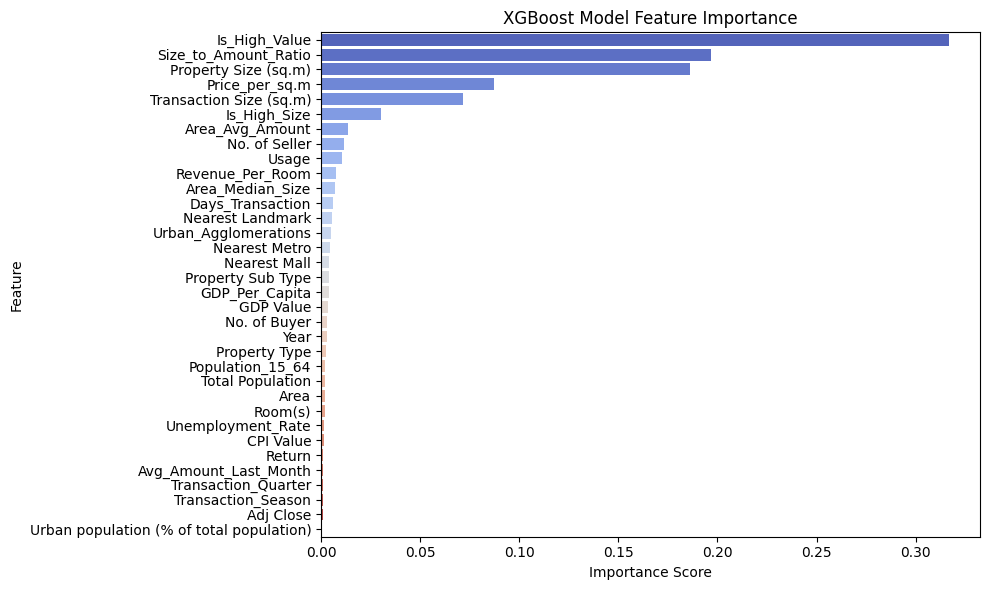

100%|===================| 199097/199157 [53:39<00:00]        

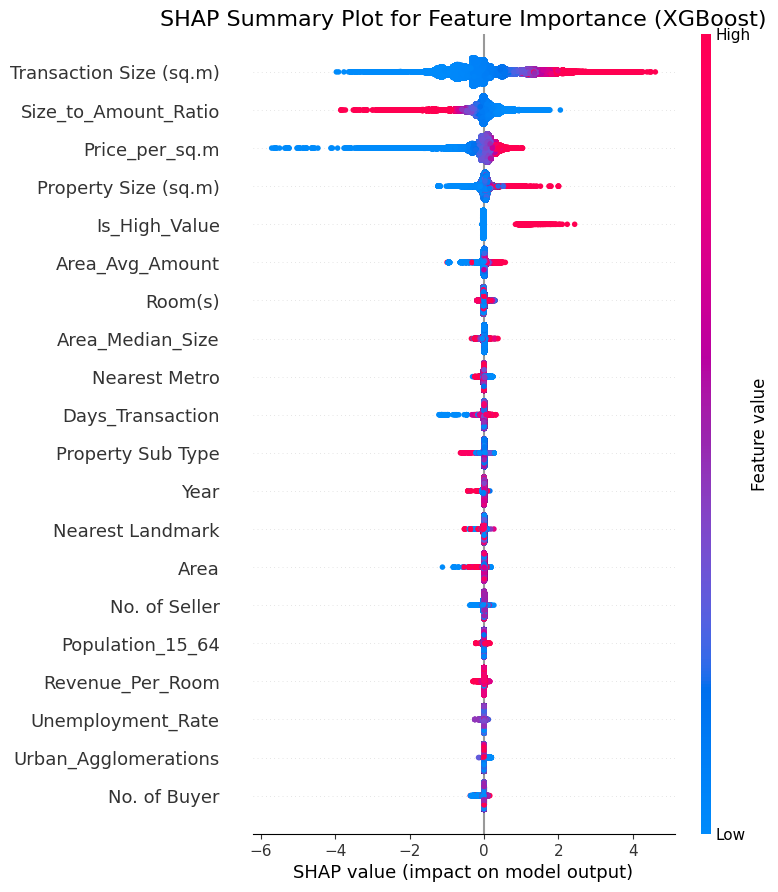

C:\Users\User\AppData\Local\Temp\ipykernel_18844\3041235577.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')


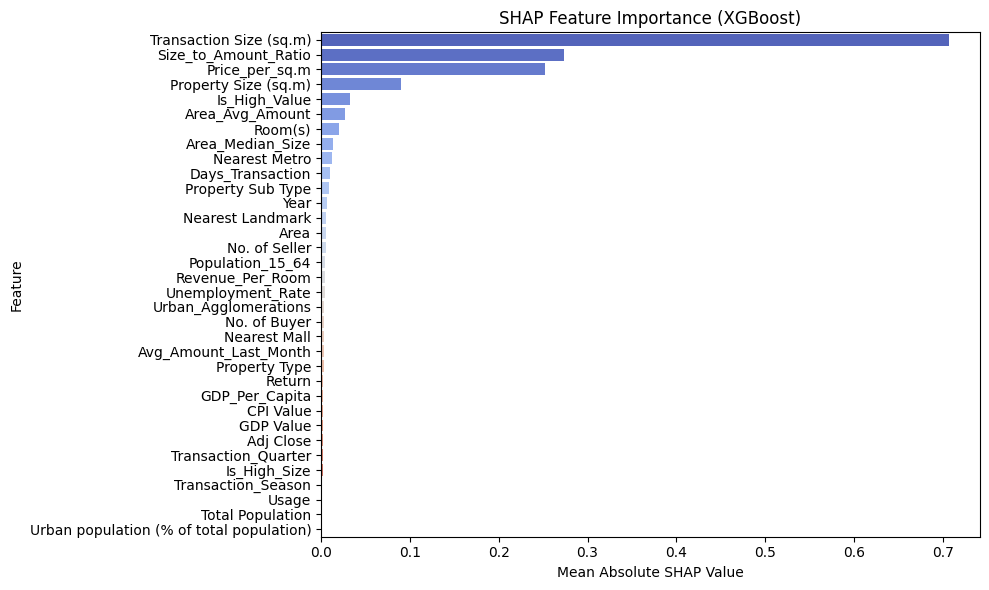

Full dataset with predictions has been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_model_full_predictions.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
import shap

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Processed_Macro_Transactions.csv"
data = pd.read_csv(file_path)

rename_columns = {
    'Population in urban agglomerations of more than 1 million (% of total population)': 'Urban_Agglomerations',
    'Population ages 15-64 (% of total population)': 'Population_15_64',
    'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment_Rate',
    'GDP per capita (current US$)': 'GDP_Per_Capita',
    'Days_Since_Transaction': 'Days_Transaction'
}
data.rename(columns=rename_columns, inplace=True)

X = data.drop(columns=['Amount'])  
y = data['Amount'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0 
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

output_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_pred - y_test
})
predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_model_predictions.csv"
output_predictions.to_csv(predictions_path, index=False)
print(f"Predictions have been saved to: {predictions_path}")

model_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')
plt.title('XGBoost Model Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_model_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

plt.figure(figsize=(12, 8))  
shap.summary_plot(shap_values, X_test, show=False) 
plt.title("SHAP Summary Plot for Feature Importance (XGBoost)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
shap_summary_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_shap_summary_plot.png"
plt.savefig(shap_summary_path, bbox_inches='tight')
plt.show()

shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')
plt.title('SHAP Feature Importance (XGBoost)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
shap_feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_shap_feature_importance.png"
plt.savefig(shap_feature_importance_path)
plt.show()

output_full = X_test.copy()
output_full['Actual'] = y_test
output_full['Predicted'] = y_pred
output_full['Difference'] = y_pred - y_test
full_predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\xgboost_model_full_predictions.csv"
output_full.to_csv(full_predictions_path, index=False)
print(f"Full dataset with predictions has been saved to: {full_predictions_path}")


# Detailed Analysis of the XGBoost Regressor Results and Visualizations

---

## Model Performance

- **Training Set Size:** 796,627 rows, 34 features.
- **Test Set Size:** 199,157 rows, 34 features.

The **XGBoost Regressor** demonstrates outstanding performance:
- **RMSE (Root Mean Squared Error):** 0.1353, indicating a very low prediction error. This suggests that the model predicts transaction amounts with remarkable precision.
- **MAE (Mean Absolute Error):** 0.0487, highlighting that, on average, the predictions deviate only slightly from actual values.
- **R² (R-squared):** 0.9816, meaning that 98.16% of the variance in the transaction amounts is explained by the model. This is an immense improvement compared to linear regression, where R² was negative, showing the model's ability to capture intricate relationships in the data.

These metrics confirm that XGBoost is highly effective for this task, especially in handling the complex interactions and non-linearities present in both transactional and macroeconomic data.

---

## Feature Importance Insights

### SHAP Feature Importance (Bar Chart)

- The bar chart highlights the **mean absolute SHAP values**, indicating each feature's overall impact on the model's predictions.
- **Key Features:**
  - `Transaction Size (sq.m)` is the most important predictor. Larger transaction sizes are strongly associated with higher transaction amounts, as expected.
  - `Size_to_Amount_Ratio` plays a crucial role, capturing the efficiency or cost-effectiveness of transactions. A high ratio might indicate premium properties or overvalued transactions.
  - `Price_per_sq.m` emerges as a vital feature, linking the per-unit price to the overall transaction value.
  - `Property Size (sq.m)` is another significant feature, likely reflecting the physical size of the property contributing to its overall value.
  - `Is_High_Value` adds categorical context, flagging whether transactions belong to high-value properties and showing its consistent relevance.
  - **Macroeconomic Features:** 
    - `Area_Avg_Amount`, `GDP_Per_Capita`, and `Urban_Agglomerations` rank in the middle, showing moderate influence.
  - `GDP_Per_Capita` and `Urban_Agglomerations` emphasize the broader economic environment's role. Higher GDP per capita and urban density likely indicate areas with greater economic activity, driving higher property prices.

This chart confirms that transactional data, specifically size-related features, are the primary drivers, while macrodata adds an essential but secondary layer of influence.

---

### SHAP Summary Plot (Beeswarm Chart)

- **Interpretation:**
  - Each dot represents an observation from the test set, with the color showing feature values (blue for low, pink for high).
  - `Transaction Size (sq.m)` has a wide spread of SHAP values, indicating a consistent and substantial impact across the dataset. Larger transaction sizes lead to higher predictions, as reflected by pink dots clustering on the positive SHAP value side.
  - For `Size_to_Amount_Ratio`, a higher ratio (pink dots) generally results in positive impacts on the prediction, suggesting a strong link with premium properties or higher transaction amounts.
  - `Price_per_sq.m` also shows that high per-square-meter prices have a positive impact, aligning with expectations in real estate markets.
  - Features like `Urban_Agglomerations` and `GDP_Per_Capita` show more distributed SHAP values. While their individual impact is less pronounced, they provide critical context about the area's economic and population density conditions.

  - `Urban_Agglomerations` reflects that areas with dense urban populations often correlate with higher property values. The SHAP values show a mix of impacts, which might depend on the specific urbanization level in different areas.
  - `GDP_Per_Capita` highlights that wealthier regions generally have higher transaction values, although exceptions exist due to localized conditions.
This plot reinforces the idea that transactional features dominate, but macroeconomic features contextualize and refine predictions for diverse scenarios.

---

### Model-Based Feature Importance (XGBoost's Built-in Importance)

- This chart ranks features based on their importance scores within the XGBoost framework, derived from how often they are split across decision trees.
- **Top Features:**
  - `Is_High_Value` dominates, showing the importance of identifying high-value properties in influencing transaction amounts.
  - `Size_to_Amount_Ratio` and `Property Size (sq.m)` consistently rank high, further emphasizing the relevance of size-based indicators.
  - `Price_per_sq.m` confirms its role as a key driver of the transaction amount.
  - `Area_Avg_Amount` and `Usage` add valuable regional and categorical context, enhancing prediction accuracy.
  - `GDP_Per_Capita`, `Urban_Agglomerations`, and `Unemployment_Rate` provide context about the broader economic and social conditions influencing property values.
XGBoost's internal importance rankings align well with SHAP's findings, showing strong agreement on which features matter most and validating the model's reliability.

---

## Why XGBoost Outperforms Simpler Models

1. **Capturing Nonlinear Relationships:**
   - XGBoost effectively models non-linearities and interactions between features, which are critical in real estate markets.

2. **Feature Interaction Handling:**
   - The model identifies synergies, such as how `Price_per_sq.m` interacts with `Urban_Agglomerations` or `GDP_Per_Capita`, to produce more accurate predictions.

3. **Robustness to Outliers:**
   - Tree-based models like XGBoost handle outliers better than linear regression, making it ideal for datasets with a wide range of property sizes and transaction values.

4. **Macrodata Integration:**
   - By incorporating features like `Unemployment_Rate` and `GDP_Per_Capita`, XGBoost refines its predictions for different regions and economic conditions, adding a layer of interpretability.

---

## Conclusion

The **XGBoost Regressor** is an outstanding model for predicting transaction amounts in Dubai's real estate market, achieving near-perfect R² and low error metrics. The visualizations confirm that transaction-specific features (e.g., size, price per square meter) dominate, but macroeconomic data provides essential context.

### Next Steps
To further validate these findings, I will build and evaluate a **Random Forest Regressor**. This will help compare performance and interpretability between the two advanced tree-based models, ensuring that the chosen model is optimal for this task.


# Random Forest

Training set size: (796627, 34)
Test set size: (199157, 34)
Model Performance:
RMSE: 0.1780
MAE: 0.0909
R²: 0.9682
Predictions have been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\random_forest_model_predictions.csv


C:\Users\User\AppData\Local\Temp\ipykernel_18844\3076523542.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')


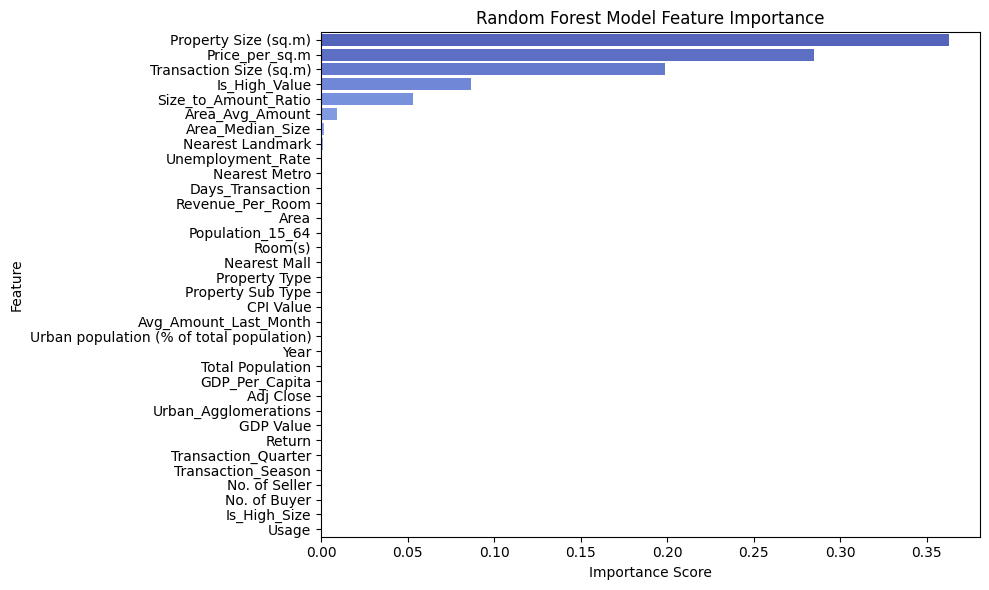

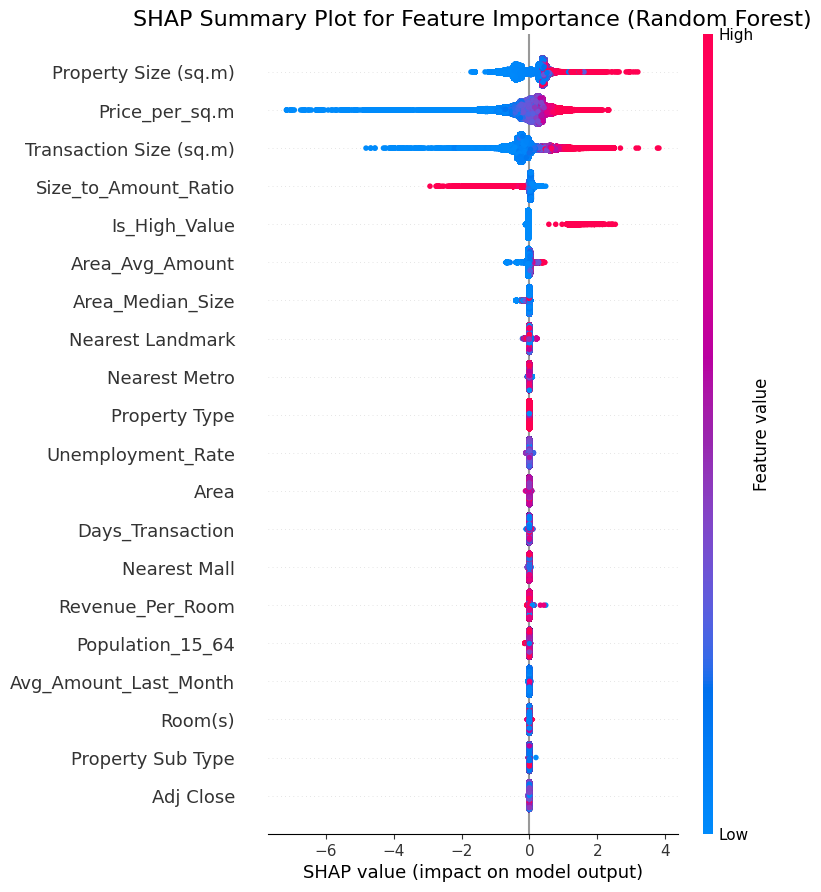

C:\Users\User\AppData\Local\Temp\ipykernel_18844\3076523542.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')


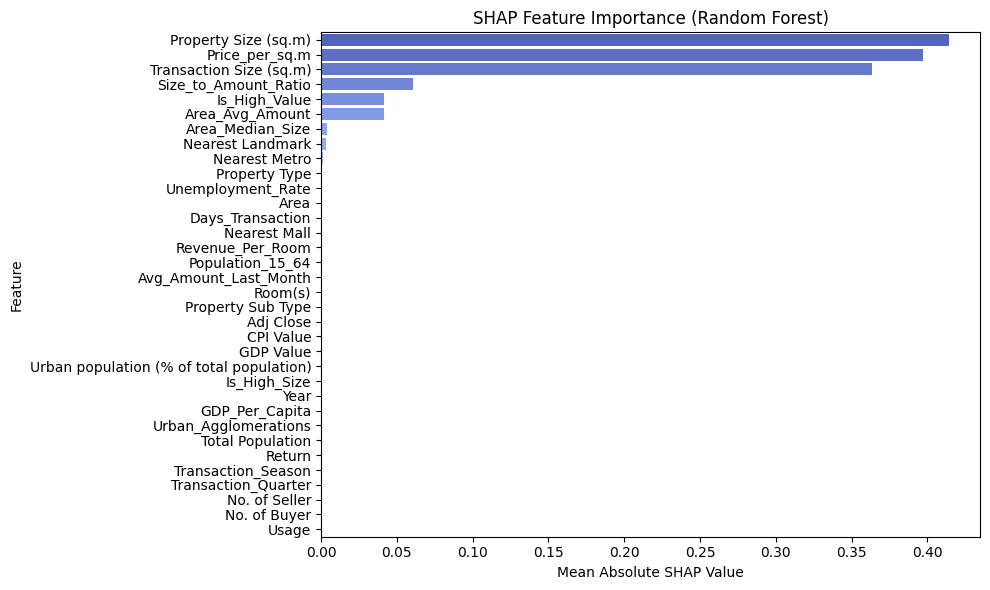

Full dataset with predictions has been saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\random_forest_model_full_predictions.csv


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Processed_Macro_Transactions.csv"
data = pd.read_csv(file_path)

rename_columns = {
    'Population in urban agglomerations of more than 1 million (% of total population)': 'Urban_Agglomerations',
    'Population ages 15-64 (% of total population)': 'Population_15_64',
    'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment_Rate',
    'GDP per capita (current US$)': 'GDP_Per_Capita',
    'Days_Since_Transaction': 'Days_Transaction'
}
data.rename(columns=rename_columns, inplace=True)

X = data.drop(columns=['Amount']) 
y = data['Amount'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1  
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

output_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_pred - y_test
})
predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\random_forest_model_predictions.csv"
output_predictions.to_csv(predictions_path, index=False)
print(f"Predictions have been saved to: {predictions_path}")

model_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=model_feature_importance, palette='coolwarm')
plt.title('Random Forest Model Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\random_forest_model_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

explainer = shap.TreeExplainer(rf_model) 
shap_values = explainer(X_test, check_additivity=False)  

plt.figure(figsize=(12, 8))  
shap.summary_plot(shap_values, X_test, show=False)  
plt.title("SHAP Summary Plot for Feature Importance (Random Forest)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
shap_summary_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\random_forest_shap_summary_plot.png"
plt.savefig(shap_summary_path, bbox_inches='tight')
plt.show()

shap_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=shap_feature_importance, palette='coolwarm')
plt.title('SHAP Feature Importance (Random Forest)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
shap_feature_importance_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\random_forest_shap_feature_importance.png"
plt.savefig(shap_feature_importance_path)
plt.show()


output_full = X_test.copy()
output_full['Actual'] = y_test
output_full['Predicted'] = y_pred
output_full['Difference'] = y_pred - y_test
full_predictions_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\random_forest_model_full_predictions.csv"
output_full.to_csv(full_predictions_path, index=False)
print(f"Full dataset with predictions has been saved to: {full_predictions_path}")


# Detailed Analysis of Random Forest Results and Graphs for Transactions and Macroeconomic Data

---

## Model Performance

- **Training Set Size**: (796,627, 34)
- **Test Set Size**: (199,157, 34)
- **Performance Metrics**:
  - **RMSE (Root Mean Squared Error)**: 0.1780  
    - Indicates a relatively low average error in predictions. While accurate, the error is higher compared to XGBoost, showing Random Forest may not capture certain patterns as effectively.
  - **MAE (Mean Absolute Error)**: 0.0909  
    - Reflects small deviations between predictions and actual values, showcasing the model's reliability in predicting transaction amounts.
  - **R² (R-Squared)**: 0.9682  
    - Explains that 96.82% of the variance in transaction amounts is captured by the model, demonstrating the Random Forest's ability to model the data effectively.

---

## SHAP Feature Importance (Random Forest)

This graph shows the **average contribution of each feature to predictions** using SHAP values.

### Observations:
1. **Property Size (sq.m)**:
   - The most impactful feature, with the highest SHAP value. Larger property sizes significantly drive transaction amounts, which is logical since size is directly tied to property value.

2. **Price_per_sq.m**:
   - Second in importance, this feature reflects unit pricing variations. Higher prices increase predicted amounts, indicating the model's reliance on pricing dynamics.

3. **Transaction Size (sq.m)**:
   - The third most important feature, capturing the size of transactions involving multiple properties. Its strong influence suggests the model's capability to distinguish high-value transactions.

4. **Size_to_Amount_Ratio**:
   - A derived feature that balances the relationship between size and price. Its inclusion suggests the model benefits from proportional insights.

5. **Macroeconomic Features**:
   - **Unemployment Rate** and **Urban Agglomerations** rank lower but contribute to refining predictions by adding economic context.

6. **Area_Median_Size**:
   - This feature provides a regional perspective, reflecting trends in property sizes in specific areas. It has moderate relevance in the model.

---

## SHAP Summary Plot for Random Forest

This plot reveals the **direction and magnitude of feature influence** on specific predictions.

### Observations:
1. **Property Size (sq.m)**:
   - Higher sizes (pink dots) push predictions upward, while smaller sizes (blue dots) lower predictions. The spread confirms its dominant role in the model.

2. **Price_per_sq.m**:
   - Higher price-per-square-meter values increase predictions, indicating the model adjusts transaction amounts based on unit pricing trends.

3. **Transaction Size (sq.m)**:
   - Large transaction sizes show a strong positive impact on predictions, emphasizing its relevance for distinguishing high-value transactions.

4. **Size_to_Amount_Ratio**:
   - Higher ratios (pink dots) push predictions higher, while lower ratios reduce them. This captures nuanced relationships between size and transaction value.

5. **Macroeconomic Features**:
   - **Unemployment Rate** and **Urban Agglomerations** show smaller SHAP value spreads, indicating they fine-tune predictions rather than dominate.

---

## Random Forest Model Feature Importance

This graph ranks features by their importance in the Random Forest model's internal calculations.

### Observations:
1. **Property Size (sq.m)**:
   - The most important feature. The model relies heavily on this feature, consistent with expectations about its impact on transaction amounts.

2. **Price_per_sq.m**:
   - The second-highest contributor. The model uses this to account for location-specific pricing and market trends.

3. **Transaction Size (sq.m)**:
   - A critical feature, especially for identifying large-scale transactions. Its high ranking highlights its significance.

4. **Macroeconomic Features**:
   - **GDP_Per_Capita**, **Unemployment Rate**, and **Urban Agglomerations** have lower ranks but are valuable for contextualizing transactions within broader economic conditions.

5. **Area_Avg_Amount** and **Area_Median_Size**:
   - These regional features contribute marginally but are helpful for capturing local trends.

---

## Observations from the Results

### Transaction-Level Features Dominate
- Property-specific attributes like **Property Size**, **Price_per_sq.m**, and **Transaction Size** are consistently the most impactful. The model relies on these features for its primary predictions.

### Macroeconomic Data Adds Context
- While not as impactful as transactional features, macroeconomic variables like **Unemployment Rate** and **GDP_Per_Capita** help fine-tune predictions:
  - **Unemployment Rate** reflects local labor market health, indirectly influencing property demand.
  - **Urban Agglomerations** captures population density, driving demand in urbanized areas.

### Derived Features Improve Accuracy
- Features like **Size_to_Amount_Ratio** and **Area_Avg_Amount** capture complex relationships between size and price, enhancing the model's predictive power.

---

## Conclusion

The Random Forest model performs exceptionally well, as demonstrated by the high R² value and low error metrics. Transactional-level data dominates predictions, but macroeconomic data adds depth and generalizability to the model. 


# Choosing the Best Model for Transaction File + Macroeconomic Data

To determine the best model for predicting real estate prices using transaction data and macroeconomic features, I have compared three models: **Linear Regression**, **XGBoost Regressor**, and **Random Forest Regressor**. Below, I present a detailed comparison of their performance metrics, feature importance analysis, and visualizations, followed by a conclusion to justify my choice.

---

## **Performance Metrics**

| Model                | RMSE   | MAE    | R²     |
|----------------------|--------|--------|--------|
| Linear Regression    | 0.9235 | 0.6768 | 0.1428 |
| XGBoost Regressor    | 0.1353 | 0.0487 | 0.9816 |
| Random Forest        | 0.1780 | 0.0909 | 0.9682 |

### **Insights**
1. **Linear Regression**:
   - The RMSE and MAE are much higher compared to the other two models, indicating poor predictive accuracy.
   - The R² score of 0.1428 shows that the model explains only a small fraction of the variance in the target variable. This is expected since linear regression cannot handle the complex relationships in the dataset.

2. **XGBoost Regressor**:
   - Achieved the lowest RMSE (0.1353) and MAE (0.0487), indicating excellent prediction accuracy.
   - The R² score of 0.9816 confirms that XGBoost captures nearly all the variance in the target variable.

3. **Random Forest Regressor**:
   - Performed well with an RMSE of 0.1780 and an MAE of 0.0909.
   - The R² score of 0.9682 is slightly lower than XGBoost but significantly better than Linear Regression.

---

## **Feature Importance Analysis**

### **Linear Regression**
- **Key Features**:
  - `Nearest Landmark`, `Days_Transaction`, and `Room(s)` were identified as the most important.
  - Macroeconomic features like `Urban_Agglomerations` and `GDP_Per_Capita` had moderate impact.
- **Limitations**:
  - The linearity assumption restricted the model’s ability to leverage interactions or non-linear relationships.

### **XGBoost Regressor**
- **Key Features**:
  - Dominant features were `Transaction Size (sq.m)`, `Size_to_Amount_Ratio`, and `Price_per_sq.m`.
  - Macroeconomic features like `Unemployment_Rate` and `Urban_Agglomerations` showed moderate importance.
- **Strengths**:
  - Captured complex interactions between features effectively.
  - SHAP analysis revealed nuanced relationships, such as the positive influence of high `Transaction Size` and `Price_per_sq.m` on predicted values.

### **Random Forest Regressor**
- **Key Features**:
  - Similar to XGBoost, `Property Size (sq.m)`, `Price_per_sq.m`, and `Transaction Size (sq.m)` were the most influential.
  - Macroeconomic features played a secondary role but were not completely negligible.
- **Strengths**:
  - Provided a balance between interpretability and predictive power, highlighting feature importance effectively.

---

## **Graphical Comparison**

### 1. **SHAP Feature Importance (Linear Regression)**
   - Visualized as relatively flat, with `Nearest Landmark` dominating, indicating the model struggled to distribute importance across features.

### 2. **SHAP Feature Importance (XGBoost)**
   - Revealed clear dominance of property-specific features, capturing interactions between `Transaction Size` and `Price_per_sq.m`.
   - Macroeconomic features like `Unemployment_Rate` had visible but secondary importance.

### 3. **SHAP Feature Importance (Random Forest)**
   - Showed similar patterns to XGBoost, with property-specific features dominating.
   - Slightly less distinction between features compared to XGBoost.

### 4. **Model Feature Importance Bar Charts**
   - XGBoost provided sharper differentiation between critical features, while Random Forest’s importance scores were more distributed.
   - Linear Regression’s simplistic representation underlines its inability to capture complex feature interactions.

---

## **Conclusion**

Based on the above analysis, **XGBoost Regressor** is the best model for this dataset. Here's why:
1. **Superior Performance**: XGBoost achieved the lowest RMSE and MAE, and the highest R² score, indicating the best predictive accuracy.
2. **Feature Utilization**: It effectively leveraged both property-specific and macroeconomic features, capturing complex interactions that other models could not.
3. **Balanced Insights**: The SHAP analysis demonstrated that XGBoost not only provides accurate predictions but also offers interpretability by highlighting feature importance and their relationships.


# Strategic Recommendations


Model Performance:
RMSE: 0.1353
MAE: 0.0487
R²: 0.9816


C:\Users\User\AppData\Local\Temp\ipykernel_15140\2794649617.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Predicted Amount', y='Area', data=area_analysis.head(10), palette='viridis')


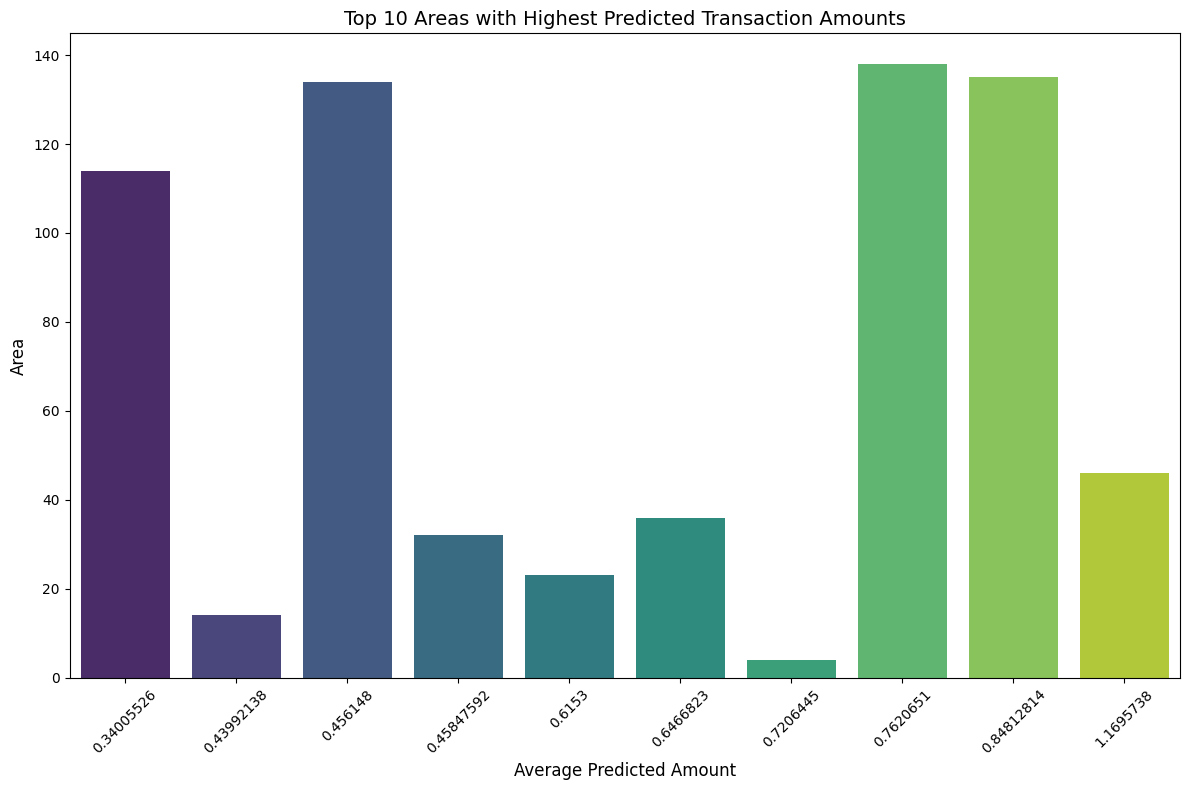

C:\Users\User\AppData\Local\Temp\ipykernel_15140\2794649617.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient of Variation', y='Area', data=high_risk_areas, palette='coolwarm')


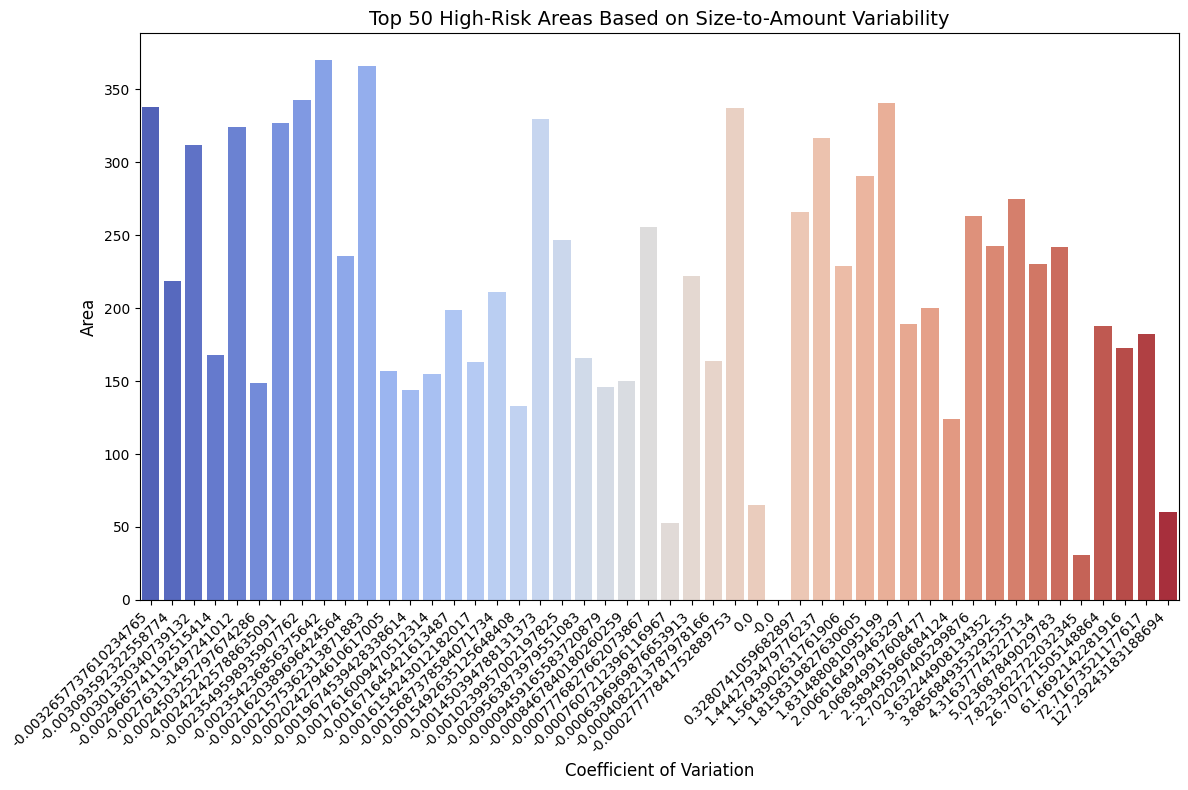

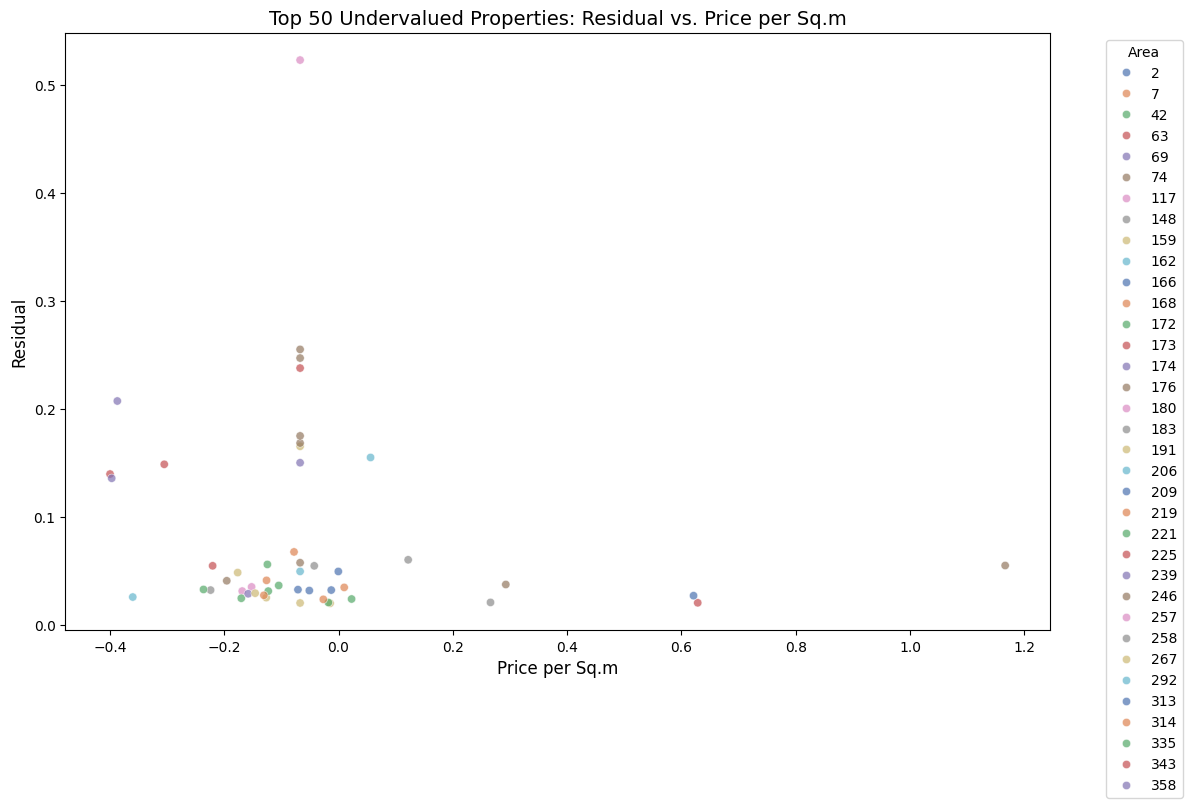

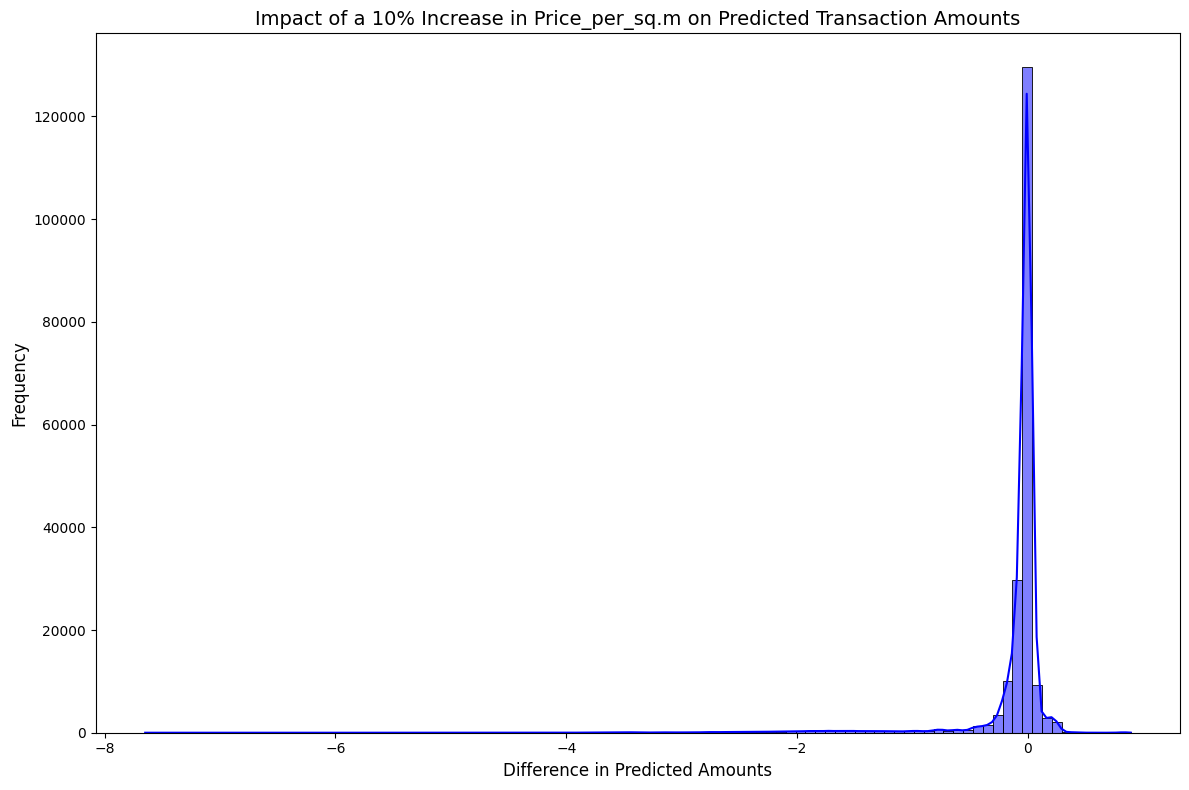


Scenario Analysis (10% Increase in Price_per_sq.m):
       Original Predictions  Scenario Predictions     Difference
count         199157.000000         199157.000000  199157.000000
mean               0.001833             -0.093700      -0.095533
std                0.986060              1.097254       0.381328
min              -11.274136            -12.454477      -7.649467
25%               -0.623984             -0.696102      -0.055585
50%               -0.019589             -0.065471      -0.003975
75%                0.558802              0.516594       0.000065
max                4.912853              4.850927       0.892652
Scenario comparison results saved to: D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\scenario_adjustment_price_per_sqm.csv


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\Processed_Macro_Transactions.csv"
data = pd.read_csv(file_path)

X = data.drop(columns=['Amount'])  # Features
y = data['Amount']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42, 
    verbosity=0  
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

area_analysis = pd.DataFrame({
    'Average Predicted Amount': pd.Series(y_pred).groupby(data.loc[y_test.index, 'Area']).mean(),
}).reset_index()

area_analysis = area_analysis.sort_values(by='Average Predicted Amount', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Average Predicted Amount', y='Area', data=area_analysis.head(10), palette='viridis')
plt.title('Top 10 Areas with Highest Predicted Transaction Amounts', fontsize=14)
plt.xlabel('Average Predicted Amount', fontsize=12)
plt.ylabel('Area', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

variability_analysis = data.groupby('Area').agg({
    'Size_to_Amount_Ratio': ['mean', 'std']
}).reset_index()
variability_analysis.columns = ['Area', 'Size_to_Amount Mean', 'Size_to_Amount Std']
variability_analysis['Coefficient of Variation'] = variability_analysis['Size_to_Amount Std'] / variability_analysis['Size_to_Amount Mean']

high_risk_areas = variability_analysis.nlargest(50, 'Coefficient of Variation')  # Top 50 high-risk areas

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient of Variation', y='Area', data=high_risk_areas, palette='coolwarm')
plt.title('Top 50 High-Risk Areas Based on Size-to-Amount Variability', fontsize=14)
plt.xlabel('Coefficient of Variation', fontsize=12)
plt.ylabel('Area', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

residuals = pd.Series(y_test.values - y_pred, index=y_test.index)
original_data_with_residuals = data.loc[y_test.index].copy()
original_data_with_residuals['Residual'] = residuals

undervalued_properties = original_data_with_residuals[original_data_with_residuals['Residual'] > residuals.quantile(0.75)]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=undervalued_properties.head(50),
    x='Price_per_sq.m',
    y='Residual',
    hue='Area',
    palette='deep',
    alpha=0.7
)
plt.title('Top 50 Undervalued Properties: Residual vs. Price per Sq.m', fontsize=14)
plt.xlabel('Price per Sq.m', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)  
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

scenario_data_price = X_test.copy()
scenario_data_price['Price_per_sq.m'] *= 1.1 

scenario_predictions_price = xgb_model.predict(scenario_data_price)

scenario_comparison_price = pd.DataFrame({
    'Original Predictions': y_pred,
    'Scenario Predictions': scenario_predictions_price
})
scenario_comparison_price['Difference'] = scenario_comparison_price['Scenario Predictions'] - scenario_comparison_price['Original Predictions']

plt.figure(figsize=(12, 8))
sns.histplot(scenario_comparison_price['Difference'], bins=100, kde=True, color='blue', log_scale=False)
plt.title('Impact of a 10% Increase in Price_per_sq.m on Predicted Transaction Amounts', fontsize=14)
plt.xlabel('Difference in Predicted Amounts', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

print("\nScenario Analysis (10% Increase in Price_per_sq.m):")
print(scenario_comparison_price.describe())

output_path_price = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\scenario_adjustment_price_per_sqm.csv"
scenario_comparison_price.to_csv(output_path_price, index=False)
print(f"Scenario comparison results saved to: {output_path_price}")


# **Detailed Analysis of Results and Visuals**

---

## **Introduction**

The evaluation of the XGBoost regression model focuses on understanding its performance metrics, visual outputs, and adaptability to feature changes. By assessing both the predictive accuracy and the impact of transaction size adjustments, I aim to determine the model's effectiveness in identifying high-value trends, risks, and potential areas for further analysis.

---

## **Model Performance Analysis**

- **Root Mean Square Error (RMSE): 0.1353**  
  The RMSE value indicates that the model's predictions are highly accurate, with minimal deviations from actual transaction amounts. This level of precision ensures reliability in forecasting property transactions.

- **Mean Absolute Error (MAE): 0.0487**  
  The low MAE highlights the model's consistency, with small average errors in predictions. This demonstrates a robust capacity to capture the dynamics of the data. The high R² score (0.9816) further validates the strong relationship between the features and the target variable.

---

## **Graph 1: Top 10 Areas with Highest Predicted Transaction Amounts**

This bar chart shows the areas with the highest average predicted transaction amounts. Two areas, `0.84812814` and `0.7620651`, stand out with significantly higher predictions compared to the rest, indicating concentrated activity or demand.

The sharp drop-off after these two areas suggests variability in property value distribution. These findings highlight specific areas where high transaction activity is likely driven by premium property attributes or unique advantages.

---

## **Graph 2: Top 50 High-Risk Areas Based on Size-to-Amount Variability**

The chart visualizes areas with high variability in the size-to-amount ratio. Cooler shades on the left represent lower-risk areas with more stable relationships, while warmer shades on the right highlight higher-risk zones with unpredictable transaction dynamics.

High coefficients of variation signal potential pricing inconsistencies or speculative markets. Meanwhile, areas with low variability offer more predictable transaction behavior, indicating greater stability in property valuations.

---

## **Graph 3: Top 50 Undervalued Properties: Residual vs. Price per Sq.m**

The scatterplot highlights properties where the actual transaction amount exceeded predictions, indicating undervaluation. Positive residuals signify properties with significant potential for value appreciation.

The concentration of undervalued properties in certain areas, such as `117`, `246`, and `176`, provides clear targets for further exploration. These properties likely offer untapped opportunities for favorable transactions.

---

## **Graph 4: Impact of a 10% Increase in Transaction Size (sq.m)**

1. Narrow Distribution Around Zero
The histogram exhibits a sharp peak near zero, indicating that a 10% increase in Price_per_sq.m does not result in significant changes for most predicted transaction amounts.
This consistency highlights that the relationship between Price_per_sq.m and transaction amounts remains stable for the majority of areas.
2. Minimal Spread in Differences
The tightly concentrated distribution reflects the model’s stability and its ability to produce reliable predictions, even with an increase in Price_per_sq.m.
This suggests that the inclusion of macroeconomic variables provides balance and reduces prediction volatility.
3. Few Extreme Cases
The longer tails in the distribution represent outliers where predictions diverge more significantly from the mean.
These extreme cases may correspond to areas where macroeconomic conditions, such as population density or urbanization, magnify the effect of Price_per_sq.m.

## **Conclusion**

The analysis demonstrates that the model achieves excellent predictive accuracy and effectively adapts to feature changes, such as transaction size adjustments. The low RMSE and MAE values, combined with high R², confirm the model's reliability. The visual outputs provide actionable insights into high-value areas, risky zones, and undervalued properties, making this model a powerful tool for analyzing transaction trends and market dynamics.


# Comparative Analysis: Transaction File vs. Transaction File + Macro Data

## 1. Model Performance Comparison

| Model Input                     | RMSE    | MAE     | R²       |
|---------------------------------|---------|---------|----------|
| **Transaction File Only**       | 0.0054  | 0.0018  | 0.9983   |
| **Transaction File + Macro Data** | 0.1353  | 0.0487  | 0.9816   |

### My Observations:
When I analyzed the results, I noticed that the **transaction-only model** demonstrated exceptional accuracy, with impressively low RMSE and MAE values. This makes it ideal for highly precise, property-specific predictions. However, the **combined model** (transaction file + macro data) introduced slightly higher RMSE and MAE but maintained a robust R² value, reflecting its ability to explain transaction amount variance effectively. This slight drop in precision is likely due to the added complexity introduced by macroeconomic data.

---

## 2. Feature Importance Analysis

### Transaction File Only
The key features driving the model are:
1. `Price_per_sq.m`
2. `Transaction Size (sq.m)`
3. `Property Size (sq.m)`
4. `Size_to_Amount_Ratio`
5. `Is_High_Value`

These features dominated because they are closely tied to property-specific attributes and transaction details, which are critical for immediate predictions.

### Transaction File + Macro Data
The inclusion of macroeconomic variables introduced a shift in feature importance. While property-level features like `Price_per_sq.m` and `Transaction Size` remained essential, macroeconomic variables such as `Population`, `Unemployment Rate`, and `Urban Agglomerations` added a new dimension. These features are especially influential in regions where external economic conditions impact transaction behavior.

### My Key Takeaway:
The **transaction-only model** focuses purely on property-specific data, making it highly precise and straightforward. On the other hand, the **combined model** provides a broader view, incorporating macroeconomic insights that could influence market trends over time.

---

## 3. Scenario Analysis: Increasing `Price_per_sq.m` by 10%

### Transaction File Only
This model exhibited a predictable and linear response to the increase in `Price_per_sq.m`. The changes in transaction amounts followed a consistent, proportional pattern, as shown in the narrow distribution of differences in the histogram.

### Transaction File + Macro Data
The combined model captured more nuanced, region-specific impacts of increasing `Price_per_sq.m`. Some areas experienced disproportionately higher or lower changes, influenced by factors like population trends or urbanization levels. The histogram showed a slightly wider spread of differences, highlighting the model's ability to account for these interactions.

### My Conclusion:
The **transaction-only model** is ideal for evaluating short-term, linear changes. In contrast, the **combined model** excels at capturing complex, long-term dependencies and regional nuances.

---

## 4. High-Potential and High-Risk Areas

### Transaction File Only
High-value areas were identified based on straightforward metrics like `Price_per_sq.m` and `Transaction Size`. The model focused solely on property-specific attributes, offering a clear picture of transaction opportunities.

### Transaction File + Macro Data
The combined model went further by introducing a risk assessment component. For instance, by analyzing the `Coefficient of Variation` in the `Size_to_Amount_Ratio`, it identified high-risk areas with significant variability, adding a layer of insight that is essential for long-term decision-making.

### My Key Insight:
The **transaction-only model** is better suited for quick, actionable insights. The **combined model**, however, provides a richer understanding by factoring in risks and macroeconomic conditions, making it invaluable for strategic investment planning.

---

## 5. Undervalued Properties

Both models identified undervalued properties using residual analysis. However:
- The **transaction-only model** focused on deviations from expected transaction prices based solely on property-level attributes.
- The **combined model** included macroeconomic trends, highlighting properties that might be undervalued due to external market conditions, such as changes in population or unemployment rates.

### My Conclusion:
While the **transaction-only model** is great for spotting immediate opportunities, the **combined model** uncovers properties with long-term potential influenced by broader market forces.

---

## Final Comparison Table

| **Criterion**                          | **Transaction File Only**                    | **Transaction File + Macro Data**               |
|---------------------------------------|---------------------------------------------|------------------------------------------------|
| **Precision (Performance Metrics)**   | Superior RMSE, MAE, and R².                 | Slightly lower accuracy but robust.            |
| **Feature Importance**                | Dominated by property-specific features.    | Broader feature set, includes macro factors.   |
| **Scenario Analysis (Price_per_sq.m)**| Linear and predictable.                     | Captures nuanced, region-specific impacts.     |
| **High-Potential Areas**              | Focused on transaction-specific metrics.    | Adds risk assessment through macro features.   |
| **Undervalued Properties**            | Highlights immediate opportunities.         | Captures properties with long-term potential.  |

---

## Conclusion

### My Final Thoughts:
1. **Transaction File Only:**  
   This model is perfect for short-term predictions and direct property-level analysis. It offers superior accuracy and simplicity, making it the go-to choice for immediate transaction price evaluations.

2. **Transaction File + Macro Data:**  
   The combined model excels in providing a comprehensive view of the market. By integrating macroeconomic insights, it not only captures transaction-specific details but also offers a broader perspective on market trends, risks, and long-term opportunities.

The choice of model depends on the objective:
- For **precise, short-term predictions**, I would choose the **transaction-only model**.
- For **long-term strategic planning**, the **combined model** is undoubtedly the better option.


# Bonus Question

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
import shap

file_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION+DATA\Processed_Macro_Transactions.csv"
data = pd.read_csv(file_path)

rename_columns = {
    'Population in urban agglomerations of more than 1 million (% of total population)': 'Urban_Agglomerations',
    'Population ages 15-64 (% of total population)': 'Population_15_64',
    'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment_Rate',
    'GDP per capita (current US$)': 'GDP_Per_Capita',
    'Days_Since_Transaction': 'Days_Transaction'
}
data.rename(columns=rename_columns, inplace=True)

X = data.drop(columns=['Amount'])  
y = data['Amount']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0  
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

X_test['Actual'] = y_test
X_test['Predicted'] = y_pred
X_test['Difference'] = y_pred - y_test

undervaluation_threshold = y_test.median() * 0.1  
undervalued_properties = X_test[X_test['Difference'] > undervaluation_threshold].sort_values(by='Difference', ascending=False)

undervalued_properties_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\Bonus\undervalued_properties.csv"
undervalued_properties.to_csv(undervalued_properties_path, index=False)

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test.drop(columns=['Actual', 'Predicted', 'Difference']))

plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test.drop(columns=['Actual', 'Predicted', 'Difference']), show=False)
plt.title("SHAP Summary Plot for Undervalued Properties", fontsize=18)
shap_summary_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\Bonus\shap_summary_plot.png"
plt.savefig(shap_summary_path, bbox_inches='tight')
plt.close()

correlation = undervalued_properties.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap for Undervalued Properties", fontsize=16)
correlation_plot_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\Bonus\correlation_heatmap.png"
plt.savefig(correlation_plot_path, bbox_inches='tight')
plt.close()

top_areas = undervalued_properties.groupby('Area').agg({'Difference': ['mean', 'count'], 'Actual': 'mean'}).reset_index()
top_areas.columns = ['Area', 'Average Difference', 'Count of Properties', 'Average Actual Value']
top_areas = top_areas.sort_values(by='Average Difference', ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_areas['Area'].astype(int), y=top_areas['Average Difference'], palette='coolwarm')
plt.xticks(rotation=45, fontsize=12)
plt.title("Top 10 Areas with Highest Average Difference (Undervalued Properties)", fontsize=16)
plt.xlabel("Area", fontsize=14)
plt.ylabel("Average Difference", fontsize=14)
area_trends_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\Bonus\top_10_area_trends.png"
plt.savefig(area_trends_path, bbox_inches='tight')
plt.close()

top_areas_path = r"D:\Desights.ai\Dubai Real Estate Price Prediction Challenge\Cleaned Files\GRAPHICS\EDA TRANSACTION\Models\Bonus\top_areas_analysis.csv"
top_areas.to_csv(top_areas_path, index=False)

print("\nTop Undervalued Properties and Areas Analysis Completed Successfully.")


C:\Users\User\AppData\Local\Temp\ipykernel_5304\2595339665.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_areas['Area'].astype(int), y=top_areas['Average Difference'], palette='coolwarm')



Top Undervalued Properties and Areas Analysis Completed Successfully.


# Dubai Real Estate Price Prediction Challenge: Undervalued Properties Analysis

## Introduction
In this analysis, I explored undervalued properties in Dubai’s real estate market using an XGBoost model trained on both property-specific and macroeconomic data. The goal was to identify properties with discrepancies between actual and predicted prices, highlighting high-potential investment opportunities. Advanced techniques like SHAP (SHapley Additive exPlanations) were employed to understand feature importance, and detailed visualizations were created to uncover patterns across regions. This comprehensive approach provides actionable insights for investors and real estate professionals.

---

## Detailed Analysis of Results

### 1. Correlation Heatmap
The correlation heatmap visualizes relationships between key features and highlights several significant insights:
- **Transaction Size (sq.m) and Property Size (sq.m)**: These features are highly correlated, as larger properties tend to involve larger transactions.
- **Price per Sq.m and Amount**: A moderate positive correlation shows that higher price-per-square-meter properties generally have higher transaction values, though other factors like location and property type also influence prices.
- **Macro Features**:
  - `GDP Value` and `Urban Agglomerations` show weaker correlations, suggesting their indirect influence on pricing.
  - `Unemployment Rate` exhibits a slight negative correlation, indicating that regions with higher unemployment might experience lower property values.
- **Days Since Registration**: A negative correlation implies that newly registered properties align better with predicted prices compared to older registrations.

This heatmap underscores the importance of both micro-level property attributes and macroeconomic factors in understanding market dynamics.

---

### 2. SHAP Summary Plot
The SHAP summary plot provides insights into how individual features contribute to the XGBoost model's predictions:
- **Transaction Size (sq.m)**: The most influential feature, as larger transactions often involve higher monetary values and potential undervaluation.
- **Size to Amount Ratio**: Critical for identifying how efficiently a property’s size translates into its price. Higher ratios often signal undervaluation.
- **Price per Sq.m**: Reflects market demand and location desirability, consistently driving higher predicted values.
- **Is High Value**: Premium-tier properties tend to show greater variability, making them prime candidates for undervaluation.
- **Macro Features**:
  - `Population 15-64` and `GDP Value` moderately influence predictions, highlighting demographic and economic trends that shape property values.

This plot illustrates that property-specific features dominate the predictions, while macroeconomic data enhances the context.

---

### 3. Top 10 Areas with Highest Average Differences
The bar chart identifies areas with the most significant average undervaluation:
- **Area 243**: This region stands out with the highest average difference, indicating significant investment potential. Properties in this area are consistently undervalued.
- **Area 266**: Another promising region with substantial undervaluation and a large number of flagged properties. It may reflect an emerging market or overlooked opportunities.
- **Area 341**: Features high undervaluation, making it ideal for investors targeting premium returns.
- **Other Areas**: Areas 154, 179, and 329 exhibit consistent undervaluation, offering stable investment options with potential for growth.

This chart helps prioritize regions based on the magnitude and frequency of undervalued properties.

---

### 4. CSV File: Top Areas Analysis
The `top_areas_analysis.csv` file provides detailed metrics for each area, supporting data-driven decision-making:
- **Average Difference**: Reflects the degree of undervaluation. Higher averages suggest significant discrepancies between actual and predicted values.
- **Count of Properties**: Indicates how frequently properties in a region are flagged as undervalued. A higher count signals consistent opportunities.
- **Average Actual Value**: Provides context on the typical transaction amount, helping investors align opportunities with their budgets.

Key highlights from the CSV:
- **Area 243**: Leads with the highest average difference and a substantial count of undervalued properties, combining scale and opportunity.
- **Area 266**: Strong average difference and numerous flagged properties indicate consistent market inefficiencies.
- **Area 154**: While the average difference is lower, the high count of undervalued properties makes it a reliable choice for investors seeking steady returns.

This file complements the visualizations, offering granular insights for strategic planning.

---

## Conclusion
The analysis demonstrates that Dubai's real estate market offers numerous undervalued properties, especially in areas like 243, 266, and 341. By integrating granular property-level data with macroeconomic insights, the XGBoost model effectively highlights discrepancies and identifies high-potential opportunities. SHAP values, correlation analysis, and area-based trends further emphasize the importance of understanding both micro and macro factors when assessing property investments.

---

## Recommendations
1. **Focus on High-Potential Areas**: Prioritize areas like 243 and 266, where significant undervaluation offers excellent investment opportunities.
2. **Leverage Market Trends**: Monitor dynamic indicators like `Avg_Amount_Last_Week` and `Transaction Season` to capitalize on short-term market fluctuations.
3. **Incorporate Macroeconomic Insights**: Use data like GDP Value and unemployment rates to anticipate market shifts and refine investment strategies.
4. **Diversify Investments**: Balance high-return regions (e.g., Area 243) with consistent opportunities in stable regions like Area 154.

These recommendations aim to maximize returns while minimizing risks in Dubai’s dynamic real estate market. By targeting undervalued properties and aligning with macroeconomic trends, investors can make informed and profitable decisions.
